In [23]:
# import necessary modules
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp

In [24]:
# import data as pandas dataframe and print first few rows to confirm all is good
file_path = 'data/fouls.csv'
df = pd.read_csv(file_path)
df.head()

,game_id,season,away_team,home_team,away_fouls,home_fouls
0,20001062,0,VAN,UTA,19,21
1,20000685,0,TOR,BOS,18,21
2,20000562,0,LAC,BOS,23,14
3,20000224,0,PHI,CHH,25,22
4,20000081,0,TOR,CLE,18,17


In [25]:
# get basic stats of away_fouls and home_fouls
df[['away_fouls', 'home_fouls']].describe().round(2)

,away_fouls,home_fouls
count,24024.00,24024.00
mean,21.00,21.02
std,4.53,4.44
min,5.00,7.00
25%,18.00,18.00
50%,21.00,21.00
75%,24.00,24.00
max,42.00,42.00


Initially, there doesn't seem to be any difference between the basic statistics of fouls called on away teams and on home teams. Next, we will calculate the average and standard deviations of each team per season. This will come in handy for our t-test later.

In [26]:
# Creating a new table for each team's average and standard deviation of fouls per season

# Combining away and home team fouls into a single dataframe
team_fouls = pd.concat([
    df[['season', 'away_team', 'away_fouls']].rename(columns={'away_team': 'team', 'away_fouls': 'fouls'}),
    df[['season', 'home_team', 'home_fouls']].rename(columns={'home_team': 'team', 'home_fouls': 'fouls'})
])

# Grouping by season and team and calculating mean and standard deviation
team_fouls_stats = team_fouls.groupby(['season', 'team']).fouls.agg(['mean', 'std']).reset_index()

# Displaying the first few rows of the new table
team_fouls_stats.head()

,season,team,mean,std
0,0,ATL,20.682927,4.204284
1,0,BOS,23.207317,4.796444
2,0,CHH,21.560976,4.400049
3,0,CHI,21.390244,4.642147
4,0,CLE,22.073171,3.829001


In [49]:
# print total teams
print('Total teams: ', team_fouls_stats.team.nunique())

# print total seasons
print('Total seasons: ', team_fouls_stats.season.nunique())

# print total seaosns times total teams
print('Total rows: ', team_fouls_stats.shape[0])

Total teams:  36
Total seasons:  20
Total rows:  596


In [27]:
# Function to calculate the number of standard deviations from the mean
def std_devs_from_mean(row, team_stats):
    season = row['season']
    team = row['team']
    fouls = row['fouls']
    team_season_stats = team_stats[(team_stats['season'] == season) & (team_stats['team'] == team)]
    if not team_season_stats.empty:
        mean_fouls = team_season_stats.iloc[0]['mean']
        std_fouls = team_season_stats.iloc[0]['std']
        return (fouls - mean_fouls) / std_fouls if std_fouls > 0 else 0
    else:
        return 0

# Applying the function to each row in the original dataset for away and home teams
df['away_fouls_std_dev'] = df.apply(lambda row: std_devs_from_mean({'season': row['season'], 'team': row['away_team'], 'fouls': row['away_fouls']}, team_fouls_stats), axis=1)
df['home_fouls_std_dev'] = df.apply(lambda row: std_devs_from_mean({'season': row['season'], 'team': row['home_team'], 'fouls': row['home_fouls']}, team_fouls_stats), axis=1)

df.head()

,game_id,season,away_team,home_team,away_fouls,home_fouls,away_fouls_std_dev,home_fouls_std_dev
0,20001062,0,VAN,UTA,19,21,-0.575466,-0.724433
1,20000685,0,TOR,BOS,18,21,-0.723780,-0.460199
2,20000562,0,LAC,BOS,23,14,0.282045,-1.919613
3,20000224,0,PHI,CHH,25,22,0.286651,0.099777
4,20000081,0,TOR,CLE,18,17,-0.723780,-1.324933


In this section, we perform a paired sample t-test to assess whether there is a significant difference in the standard deviations of fouls called against away teams compared to home teams, thereby evaluating the potential for officiating bias. The t-test is particularly suitable for this analysis because it compares the means of two related groups (in this case, the standard deviations of fouls for home and away teams within the same games) to see if they are statistically different from each other. By calculating the t-statistic and the associated p-value, we can infer whether the differences observed in our data are likely to occur by chance. A low p-value (we will be using a threshold of 0.05) would indicate that the differences in foul calls are statistically significant, suggesting a potential bias in officiating. This method provides a rigorous statistical approach to investigate patterns that might otherwise be hidden in the complexities of sports data.

First, we will perform a t-test on each team individually to see if there is a significant difference in the standard deviations of fouls called against them when they are playing at home versus away. We will then perform a t-test on the entire dataset to see if there is a significant difference in the standard deviations of fouls called against home teams versus away teams in general. We will do this for each season individually, as well as for the entire dataset.

In [28]:

# Performing a t-test for each home team to see if there is any officiating bias (overall)
# i.e., if away fouls are consistently more standard deviations away than home fouls

# Results dictionary
t_test_results = {}

# Iterating over each home team
for team in df['home_team'].unique():
    # Filter the games where the team is the home team
    team_games = df[df['home_team'] == team]

    # Perform a t-test
    t_stat, p_val = sp.stats.ttest_rel(team_games['away_fouls_std_dev'], team_games['home_fouls_std_dev'])

    # Store results
    t_test_results[team] = {'t_statistic': t_stat, 'p_value': p_val}

# Converting results to a dataframe for better visualization
team_t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

team_t_test_results_df.head()

c:\Users\npere\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\npere\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,t_statistic,p_value
UTA,2.723939,9.359475e-03
BOS,7.000782,3.818754e-12
CHH,-0.833772,4.057533e-01
CLE,-3.546288,4.046476e-04
MIL,1.612508,1.072895e-01


In [29]:
# Grouping by season and home team, and then performing t-tests
unique_seasons = df['season'].unique()
unique_home_teams = df['home_team'].unique()
t_test_results = {}

for season in unique_seasons:
    for team in unique_home_teams:
        team_season_data = df[(df['home_team'] == team) & (df['season'] == season)]
        # Performing t-test only if there are enough data points
        if len(team_season_data) > 1:
            t_stat, p_value = sp.stats.ttest_rel(team_season_data['away_fouls_std_dev'], team_season_data['home_fouls_std_dev'])
            t_test_results[(season, team)] = {'t_statistic': t_stat, 'p_value': p_value}

# Displaying a subset of the results for brevity
# Convert results to DataFrame for easier viewing
season_team_t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')
season_team_t_test_results_df.index.names = ['Season', 'Home Team']
season_team_t_test_results_df.head()

t_statistic   p_value
Season Home Team                       
0      UTA           2.031367  0.097940
       BOS           2.510829  0.014141
       CHH          -1.268583  0.208620
       CLE           1.375628  0.173588
       MIL           2.447643  0.019111

In [30]:
# Performing a test on all the data to see if away teams in general are called for more fouls than home teams

t_stat, p_val = sp.stats.ttest_rel(df['away_fouls_std_dev'], df['home_fouls_std_dev'])

print('t-statistic: ', t_stat)
print('p-value: ', p_val)

t-statistic:  -0.02000884382434108
p-value:  0.9840364837996676


In [31]:
# Performing a t test on each season to see if there was a season in which away teams were called for more fouls than home teams

# Results dictionary
t_test_results = {}

# Iterating over each season
for season in df['season'].unique():
    # Filter the games where the team is the home team
    season_games = df[df['season'] == season]

    # Perform a t-test
    t_stat, p_val = sp.stats.ttest_rel(season_games['away_fouls_std_dev'], season_games['home_fouls_std_dev'])

    # Store results
    t_test_results[season] = {'t_statistic': t_stat, 'p_value': p_val}

# Converting results to a dataframe for better visualization
season_t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

# Displaying the results
season_t_test_results_df.head()

,t_statistic,p_value
0,3.014583,0.002628
1,1.883139,0.059926
2,3.345822,0.000846
3,0.623578,0.533024
4,1.433551,0.151955


In [32]:
# Lets filter all our data to see if there were any t-tests performed in which the p-value was less than 0.05 (i.e., there was a statistically significant difference between the number of fouls called on away teams vs. home teams)

# Filtering the results to only show seasons where the p-value was less than 0.05
filtered_team_t_test_results_df = team_t_test_results_df[team_t_test_results_df['p_value'] < 0.05]
filtered_season_team_t_test_results_df = season_team_t_test_results_df[season_team_t_test_results_df['p_value'] < 0.05]
filtered_season_t_test_results_df = season_t_test_results_df[season_t_test_results_df['p_value'] < 0.05]

# Print how many seasons had a statistically significant difference
print('Number of seasons with statistically significant difference in fouls called on away teams vs. home teams: ', len(filtered_season_t_test_results_df))

# Print how many teams had a statistically significant difference
print('Number of teams with statistically significant difference in fouls called on away teams vs. home teams: ', len(filtered_team_t_test_results_df))

# Print how many seasons and teams had a statistically significant difference
print('Number of times a team had a season with statistically significant difference in fouls called on away teams vs. home teams: ', len(filtered_season_team_t_test_results_df))

Number of seasons with statistically significant difference in fouls called on away teams vs. home teams:  10
Number of teams with statistically significant difference in fouls called on away teams vs. home teams:  16
Number of times a team had a season with statistically significant difference in fouls called on away teams vs. home teams:  160


Let's create some graphs to display the results of our t-tests

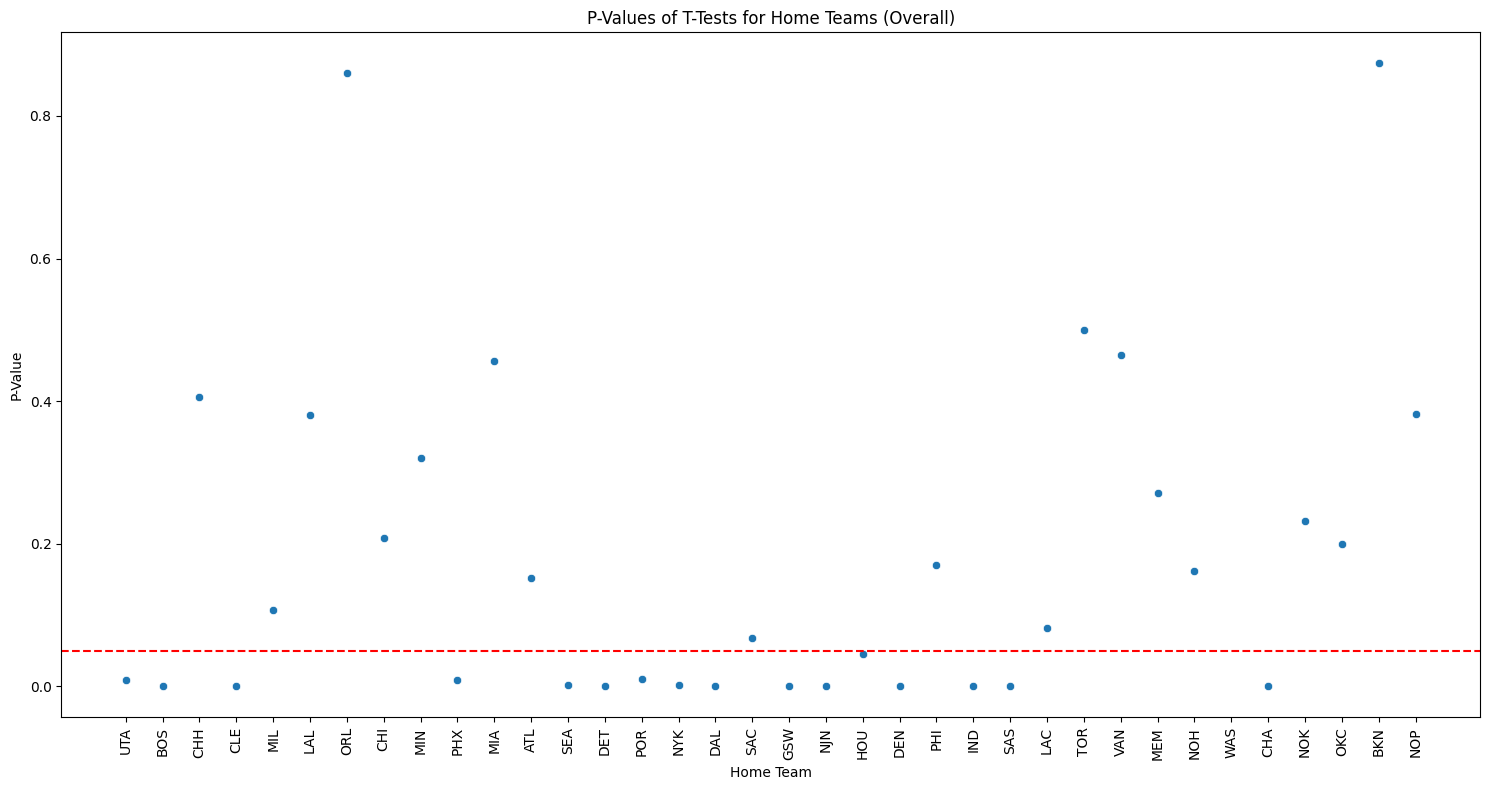

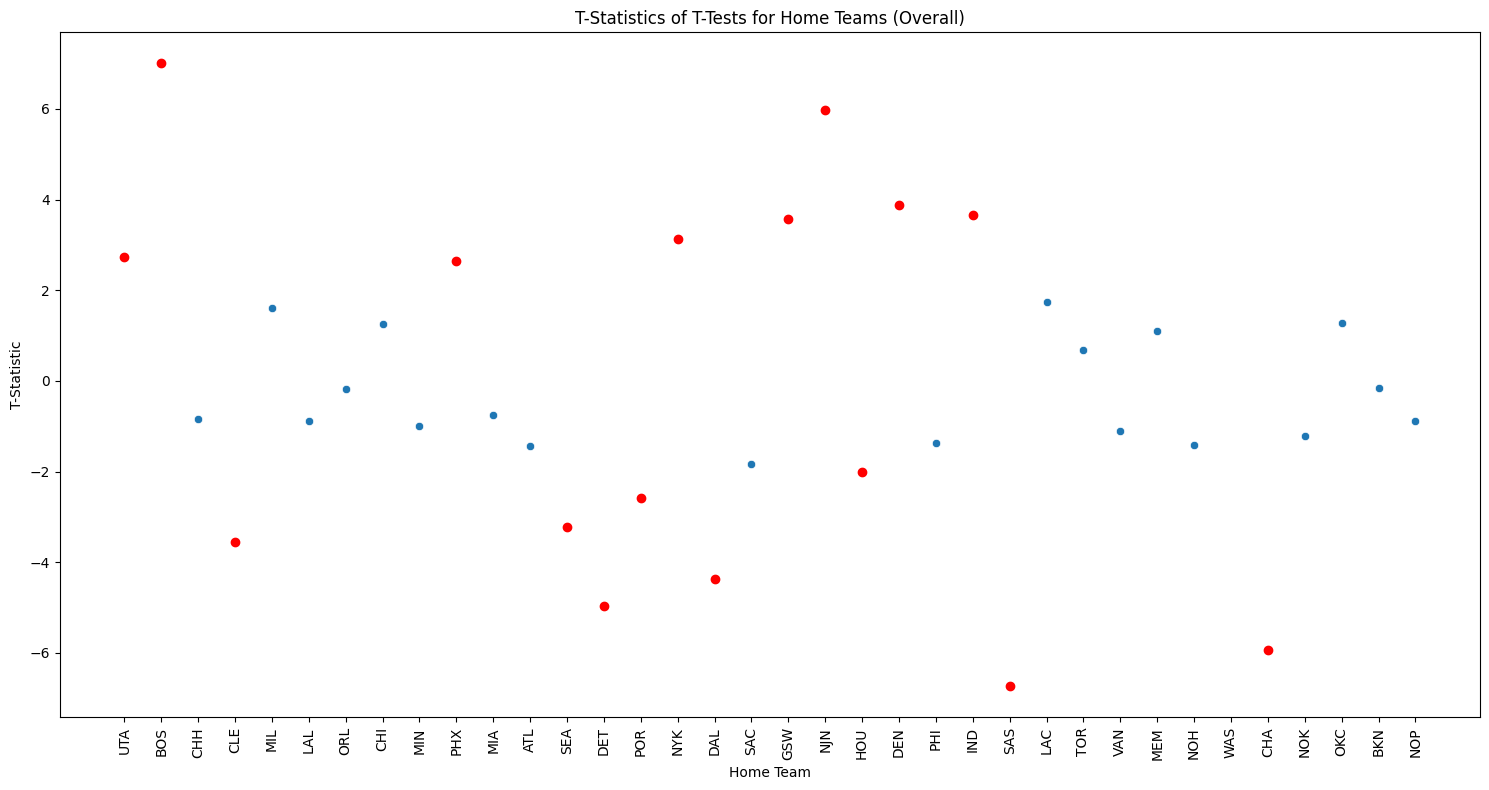

In [47]:
"""Plotting Overall Results"""

# Resetting the index of the DataFrame to make the team names a regular column
df_for_plot = team_t_test_results_df.reset_index()
df_for_plot.rename(columns={'index': 'Team'}, inplace=True)

# Visualization for P-Values of T-Test Results
plt.pyplot.figure(figsize=(15, 8))
sns.scatterplot(data=df_for_plot, x='Team', y='p_value')
plt.pyplot.axhline(0.05, color='red', linestyle='--')  # Significance level line
plt.pyplot.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.pyplot.title('P-Values of T-Tests for Home Teams (Overall)')  # Title of the plot
plt.pyplot.ylabel('P-Value')  # Y-axis label
plt.pyplot.xlabel('Home Team')  # X-axis label
plt.pyplot.tight_layout()  # Adjust layout
plt.pyplot.show()  # Display the plot

#Visulation for T Statistics of T-Test Results (color coded by p-value significance)
plt.pyplot.figure(figsize=(15, 8))
sns.scatterplot(data=df_for_plot, x='Team', y='t_statistic')
plt.pyplot.xticks(rotation=90)  # Rotate x-axis labels for readability
# make dots red if the team had a statistically significant difference (p value < 0.05)
for index, row in df_for_plot.iterrows():
    if row['p_value'] < 0.05:
        plt.pyplot.scatter(row['Team'], row['t_statistic'], color='red')
plt.pyplot.title('T-Statistics of T-Tests for Home Teams (Overall)')  # Title of the plot
plt.pyplot.ylabel('T-Statistic')  # Y-axis label
plt.pyplot.xlabel('Home Team')  # X-axis label
plt.pyplot.tight_layout()  # Adjust layout
plt.pyplot.show()  # Display the plot


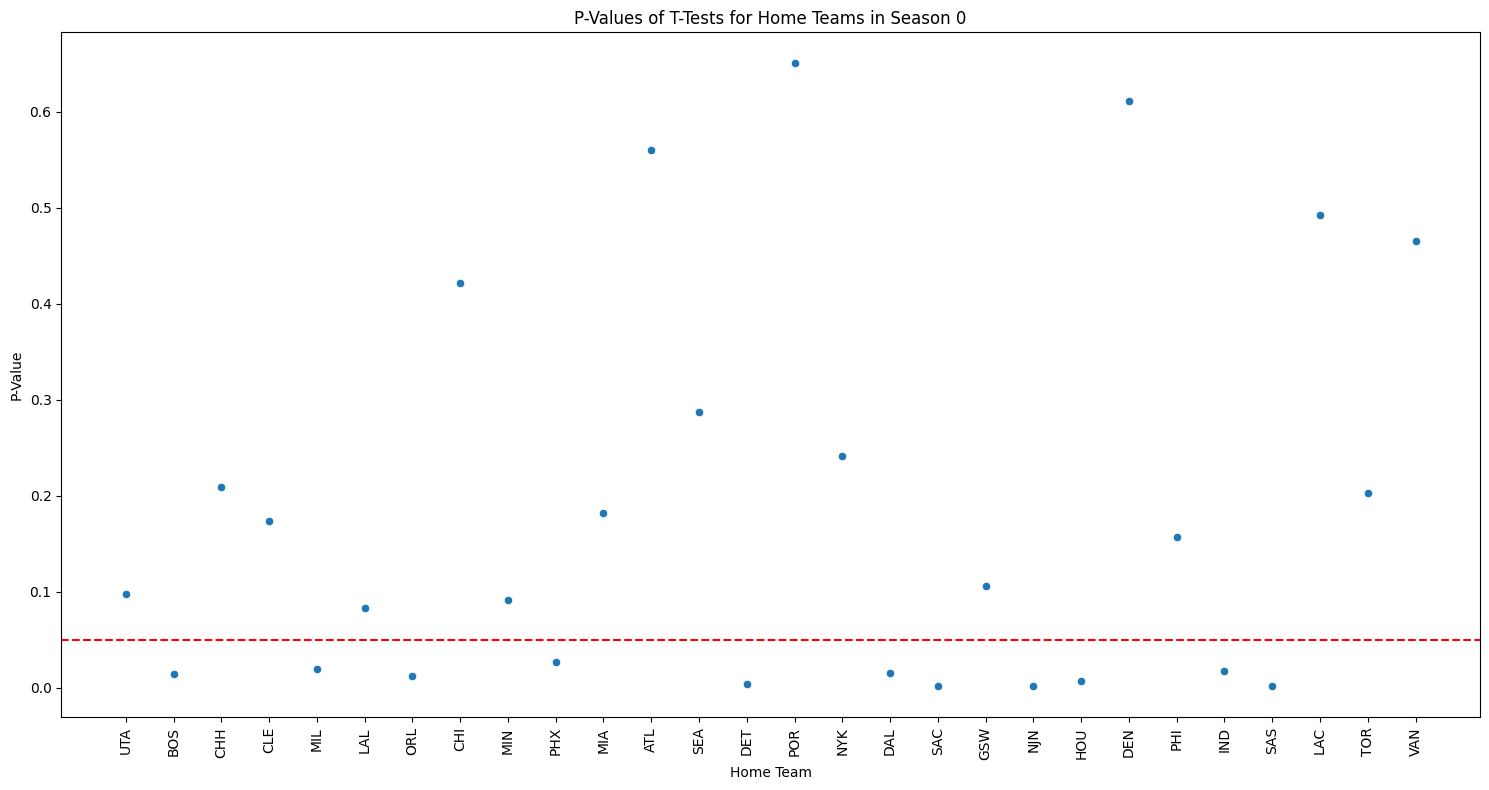

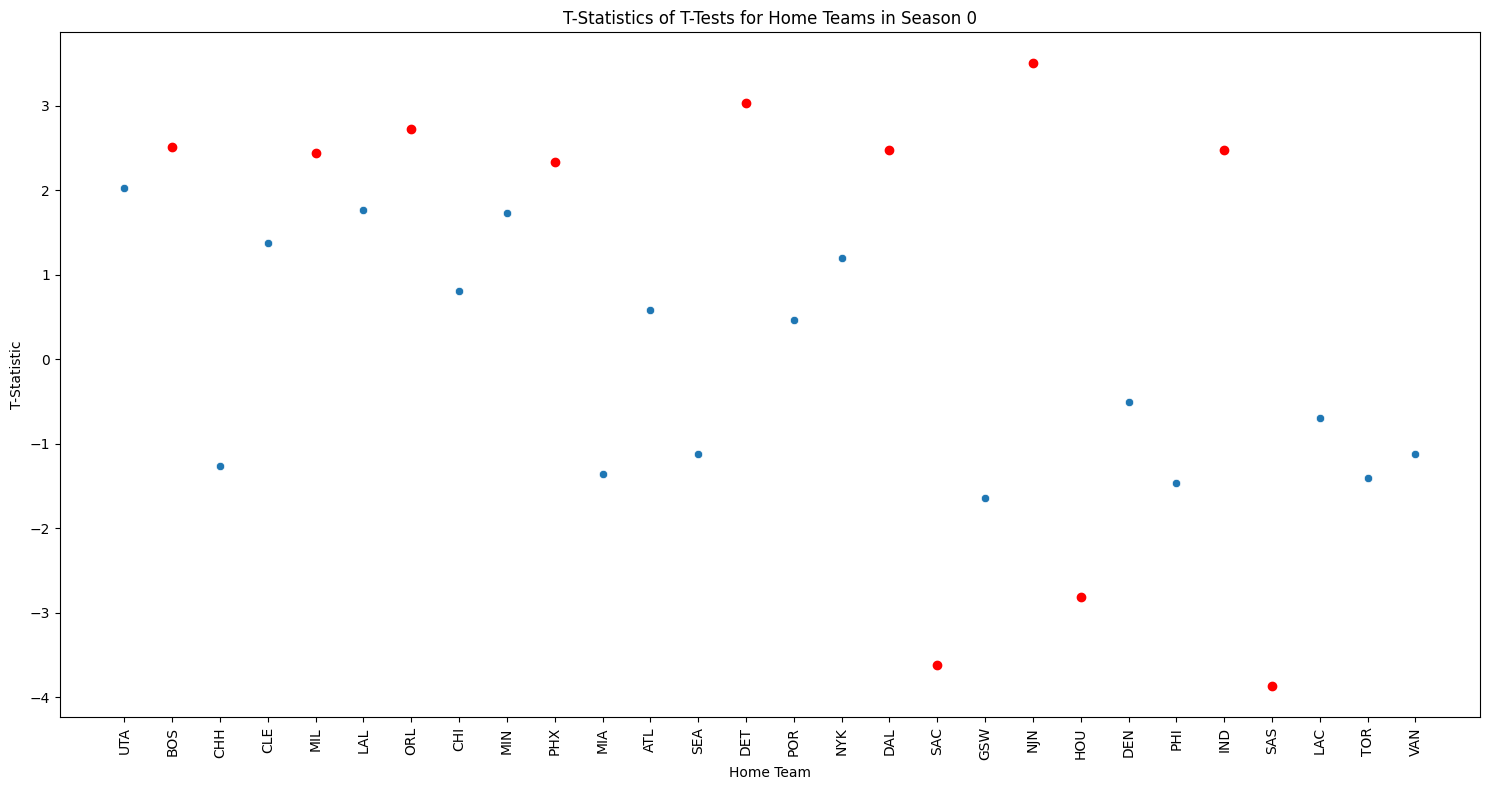

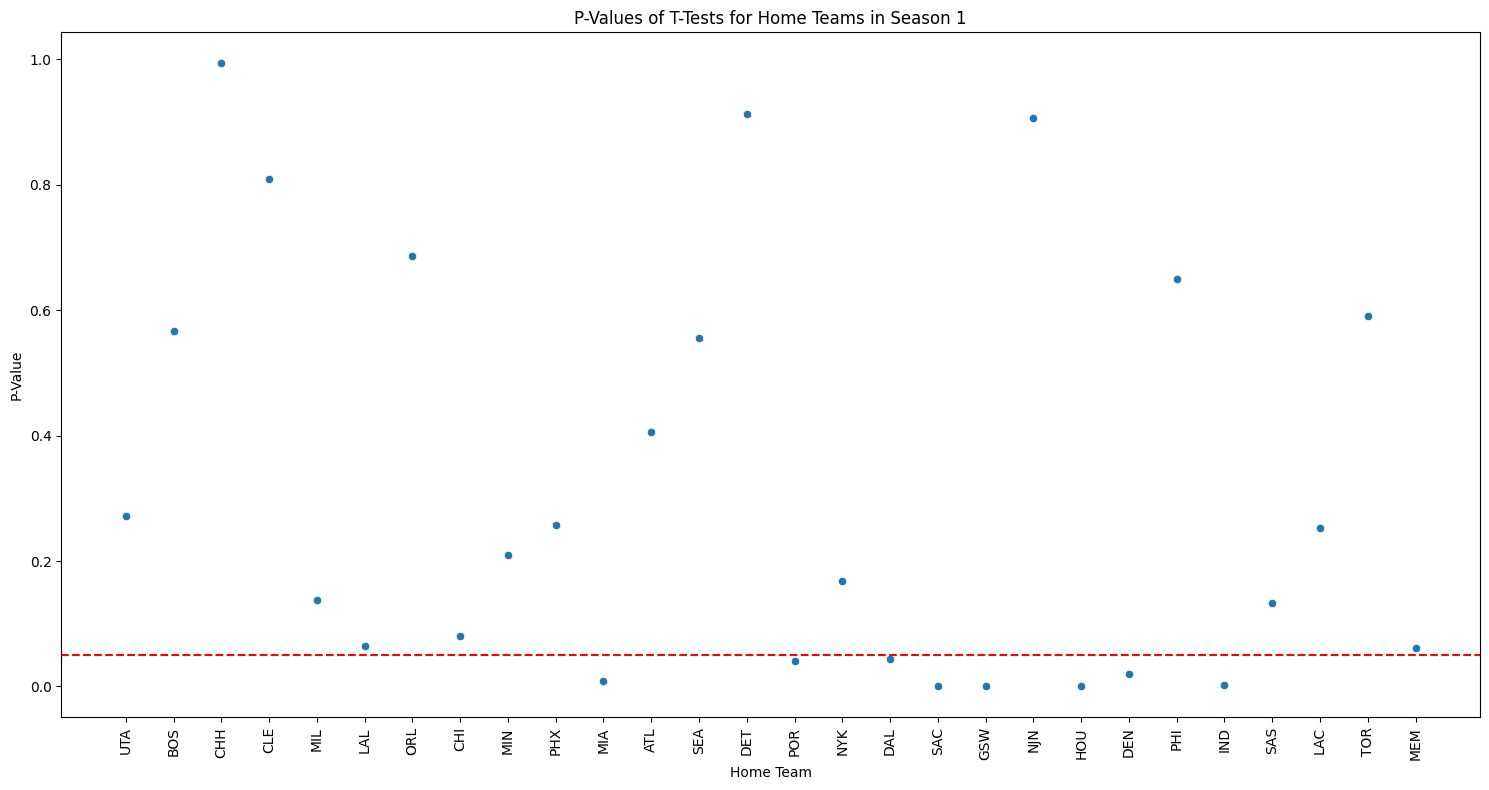

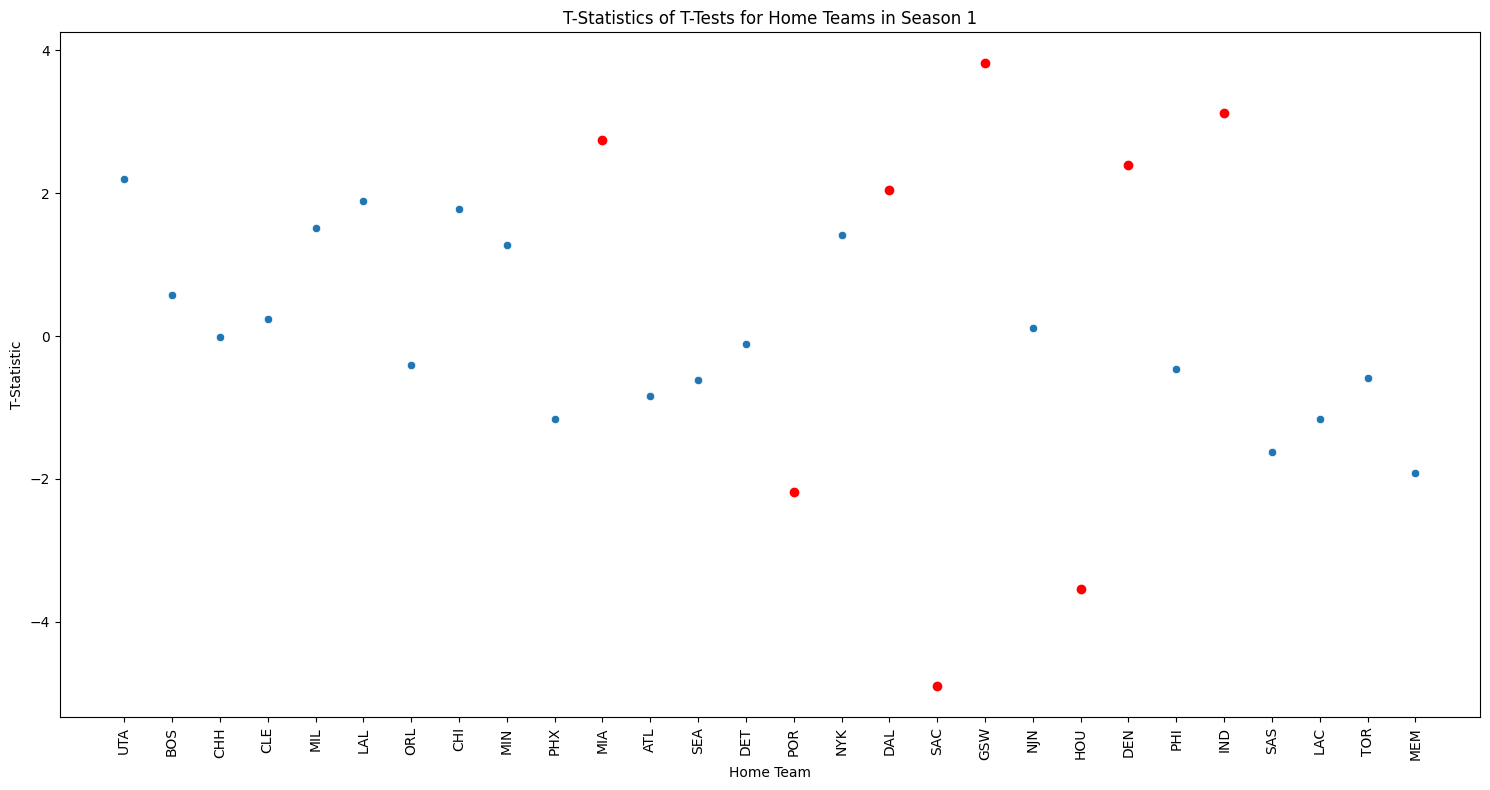

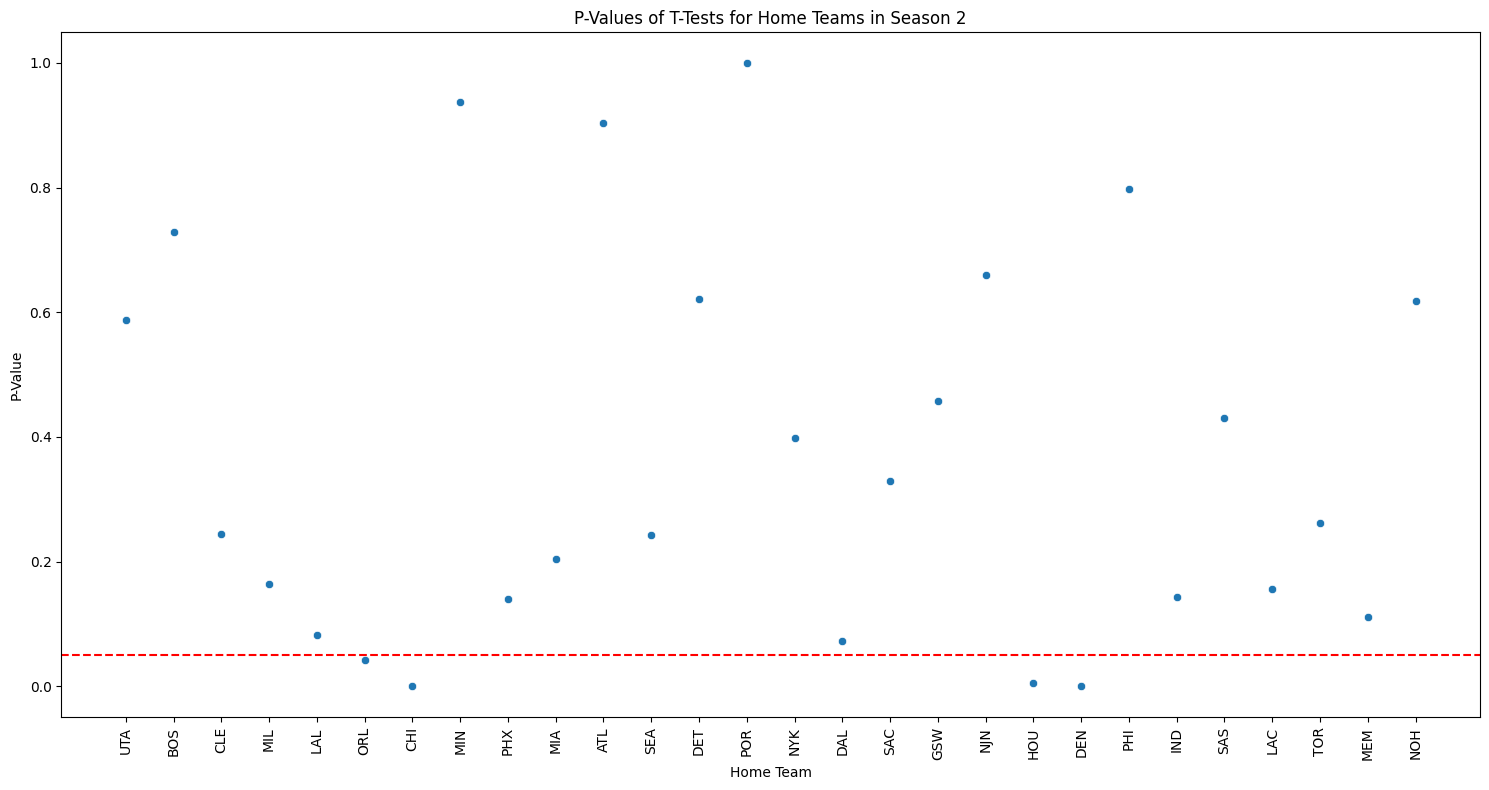

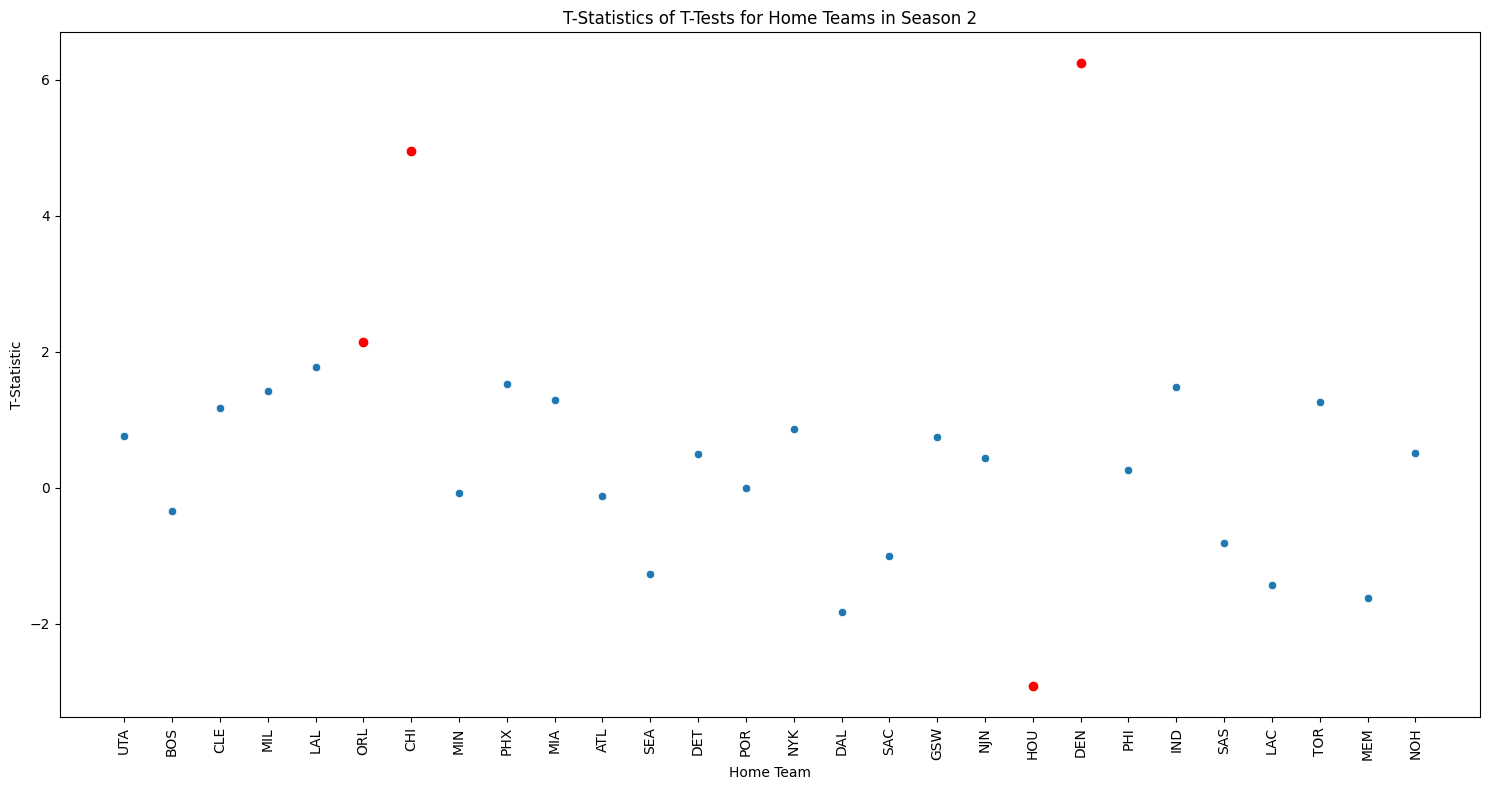

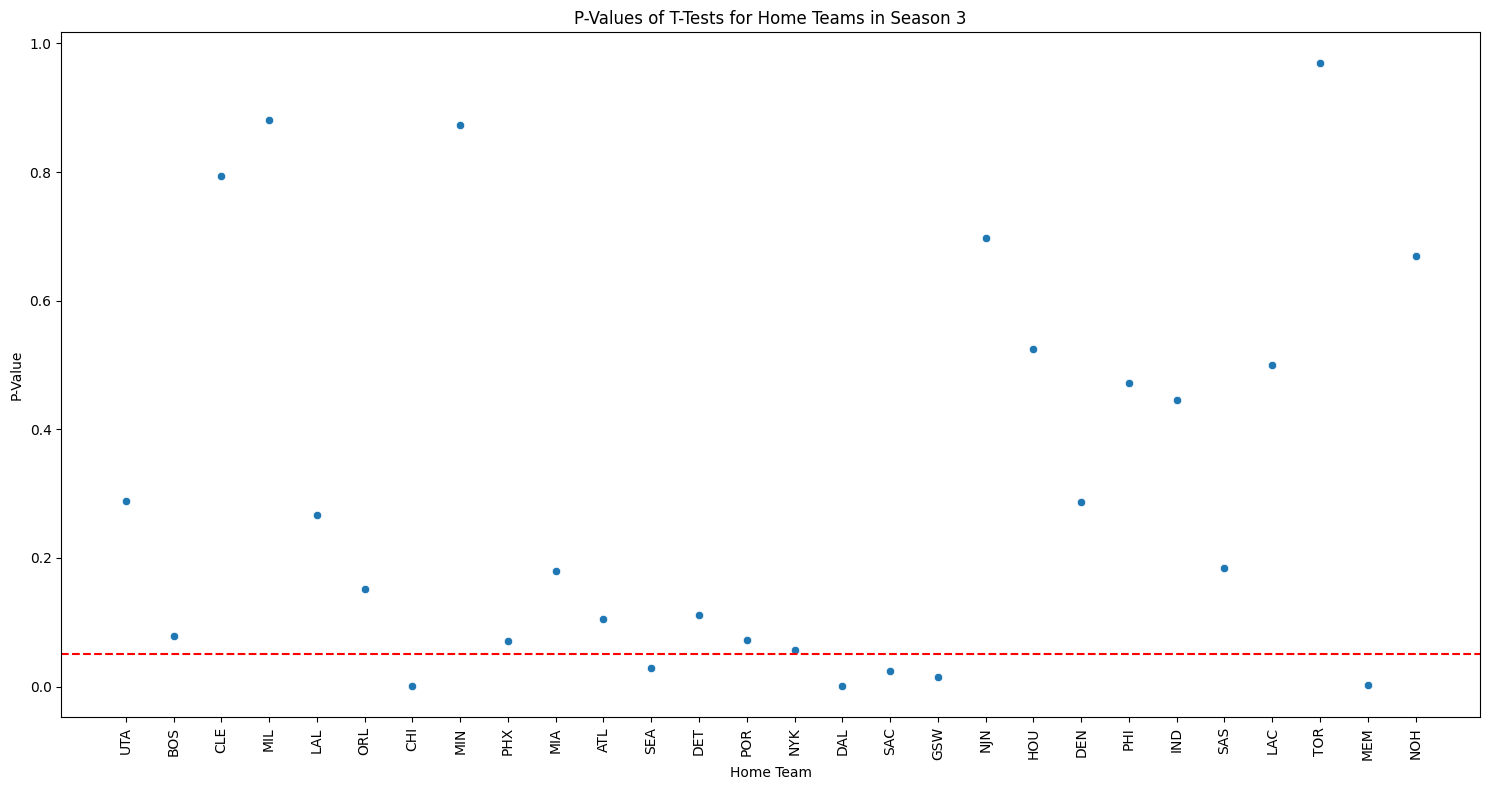

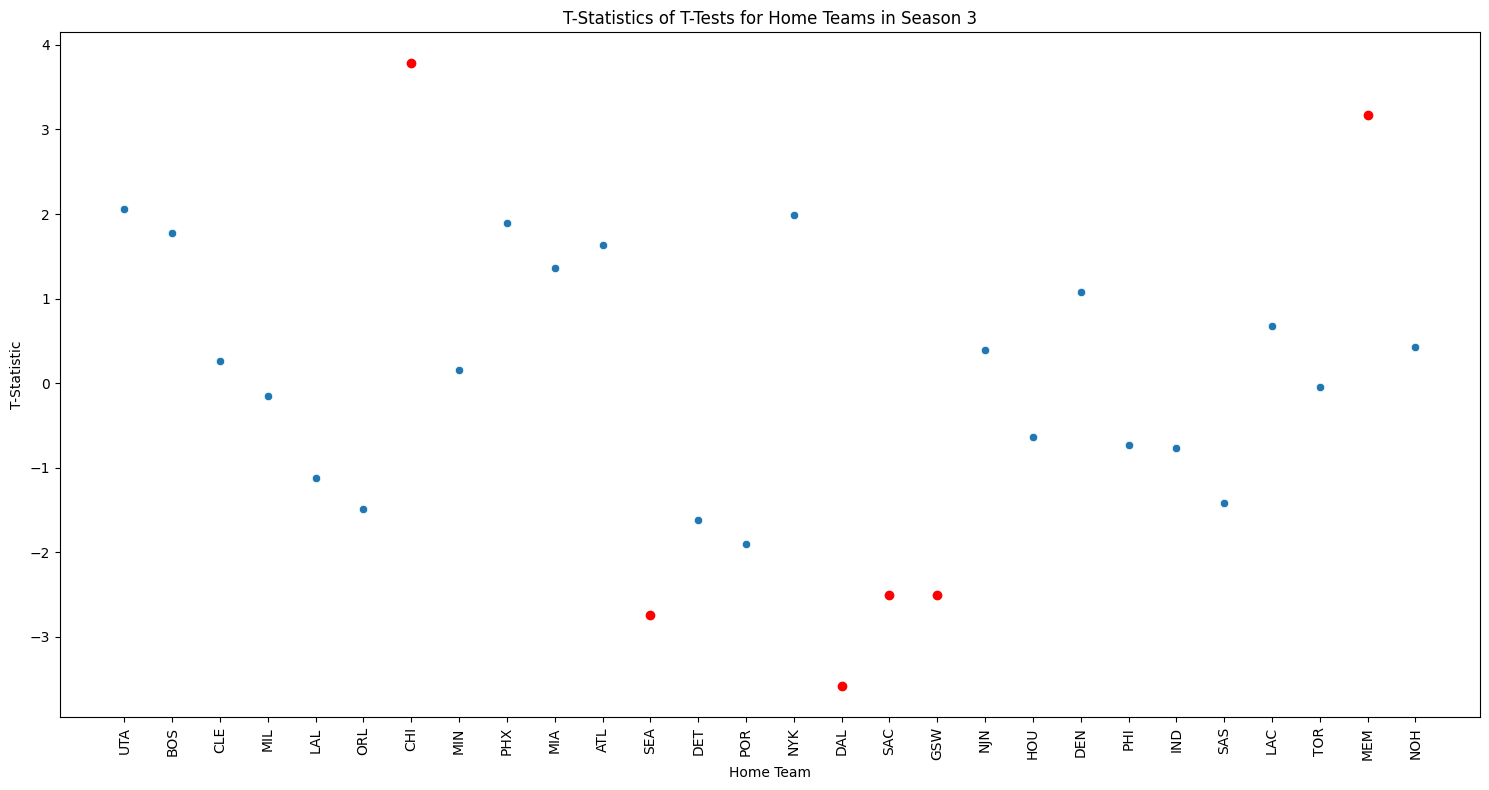

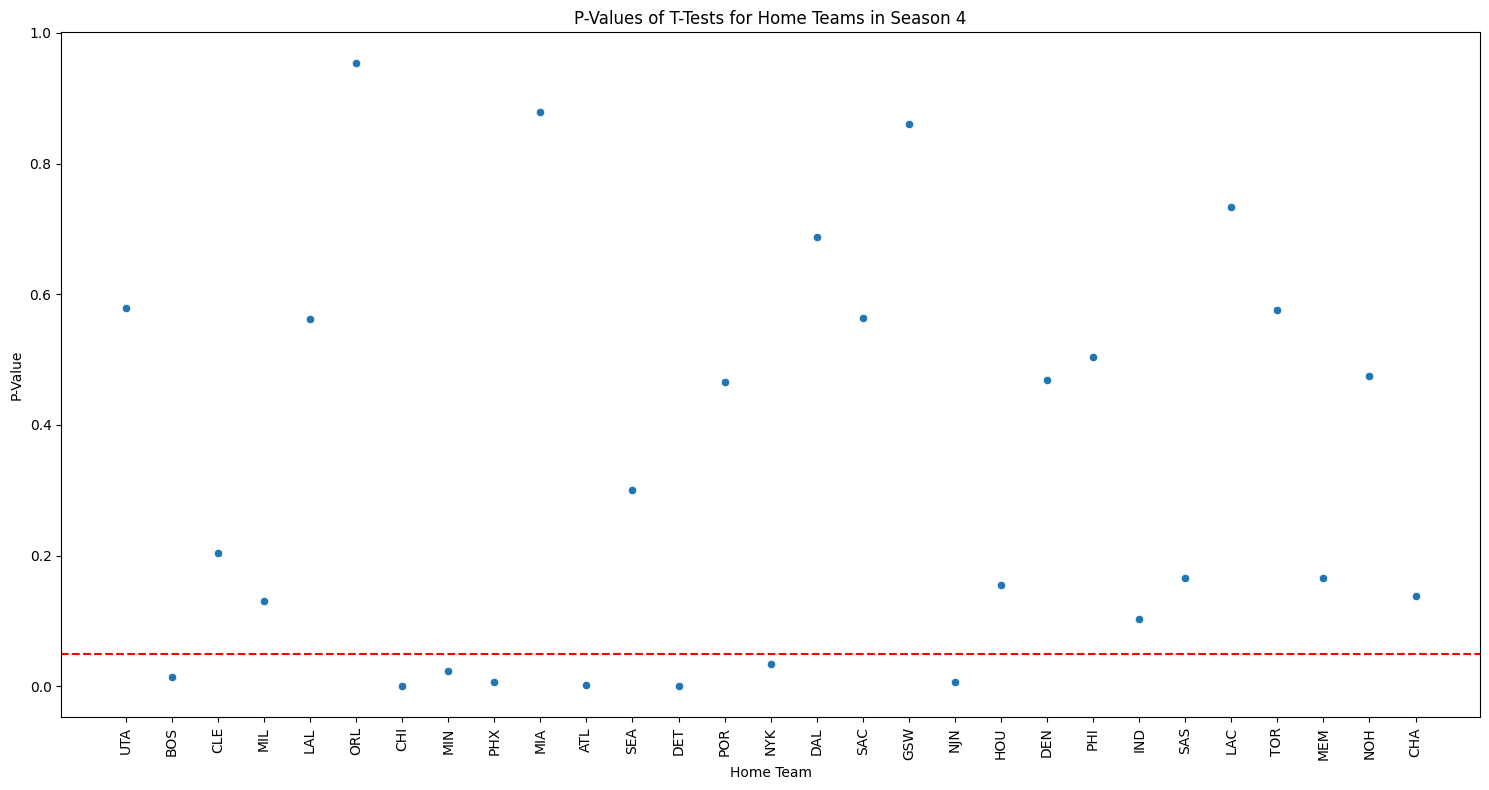

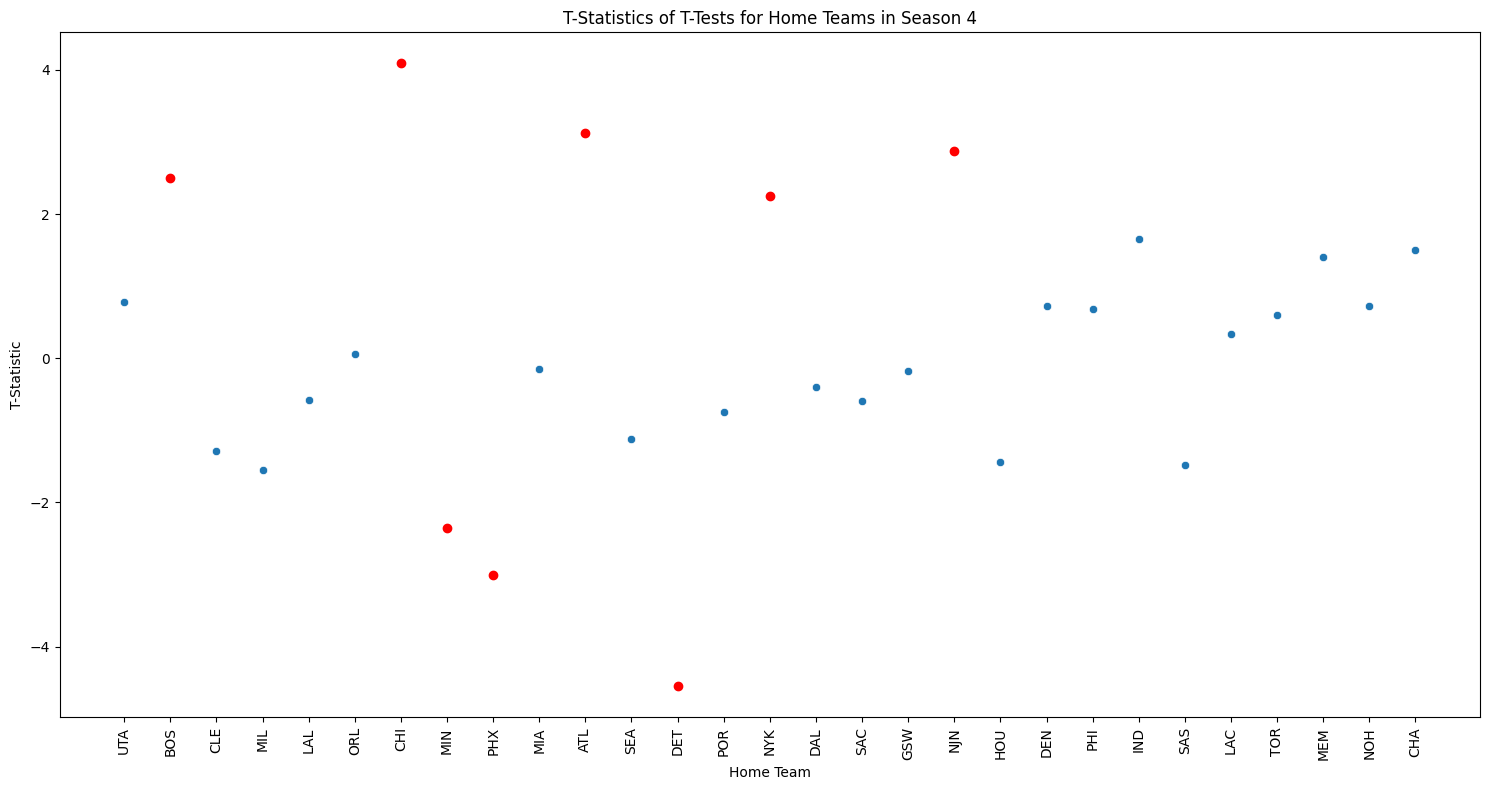

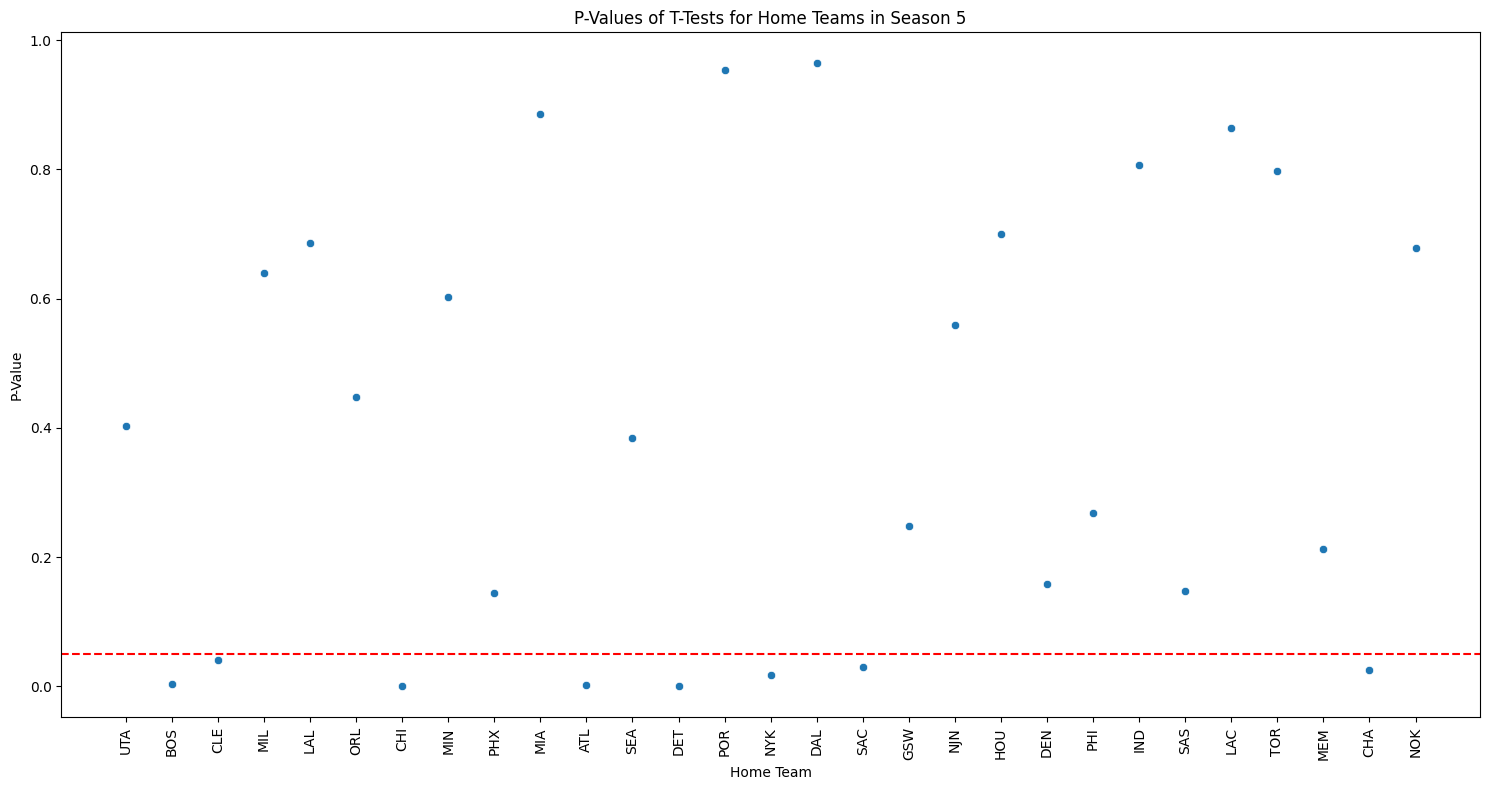

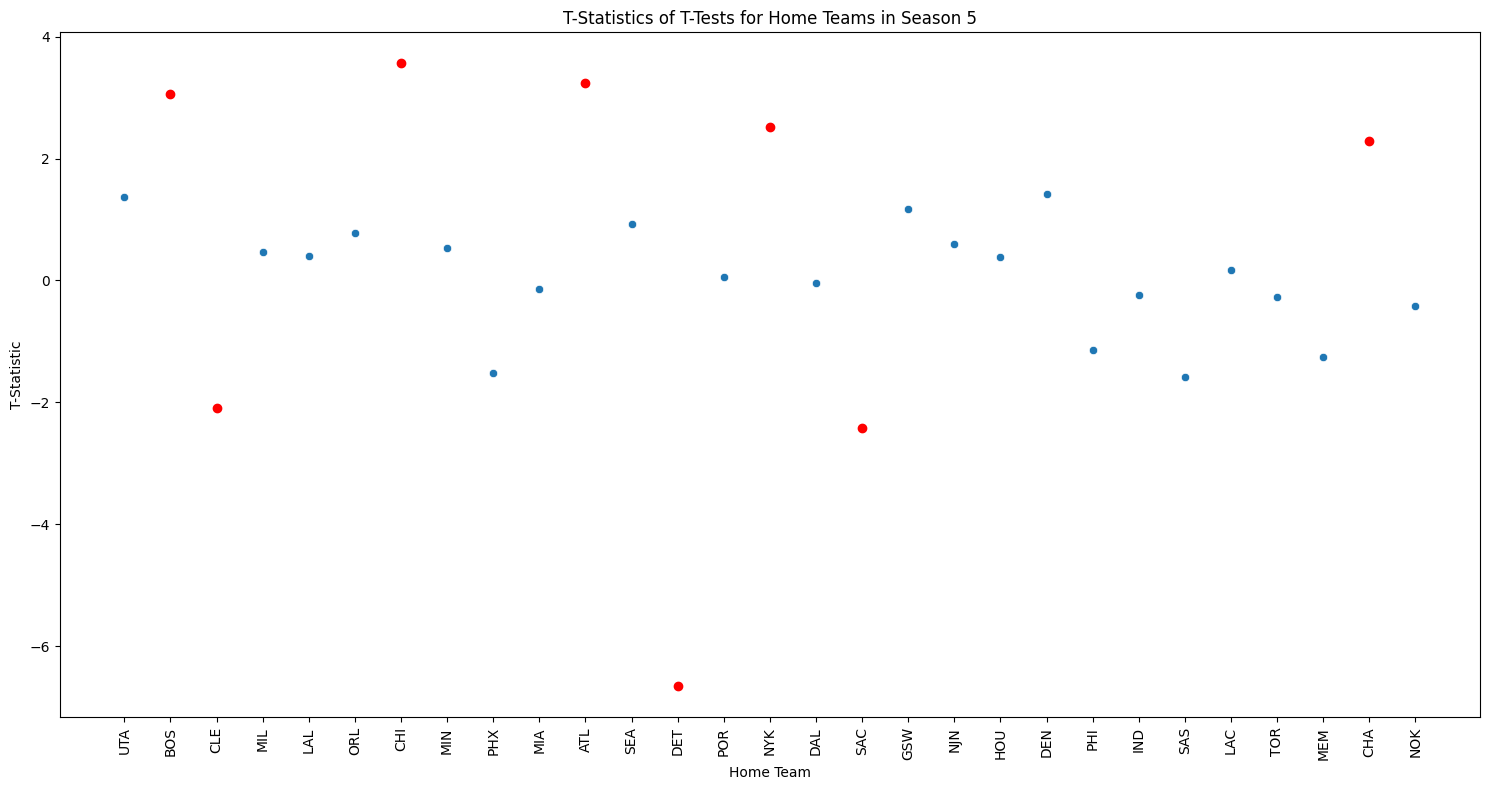

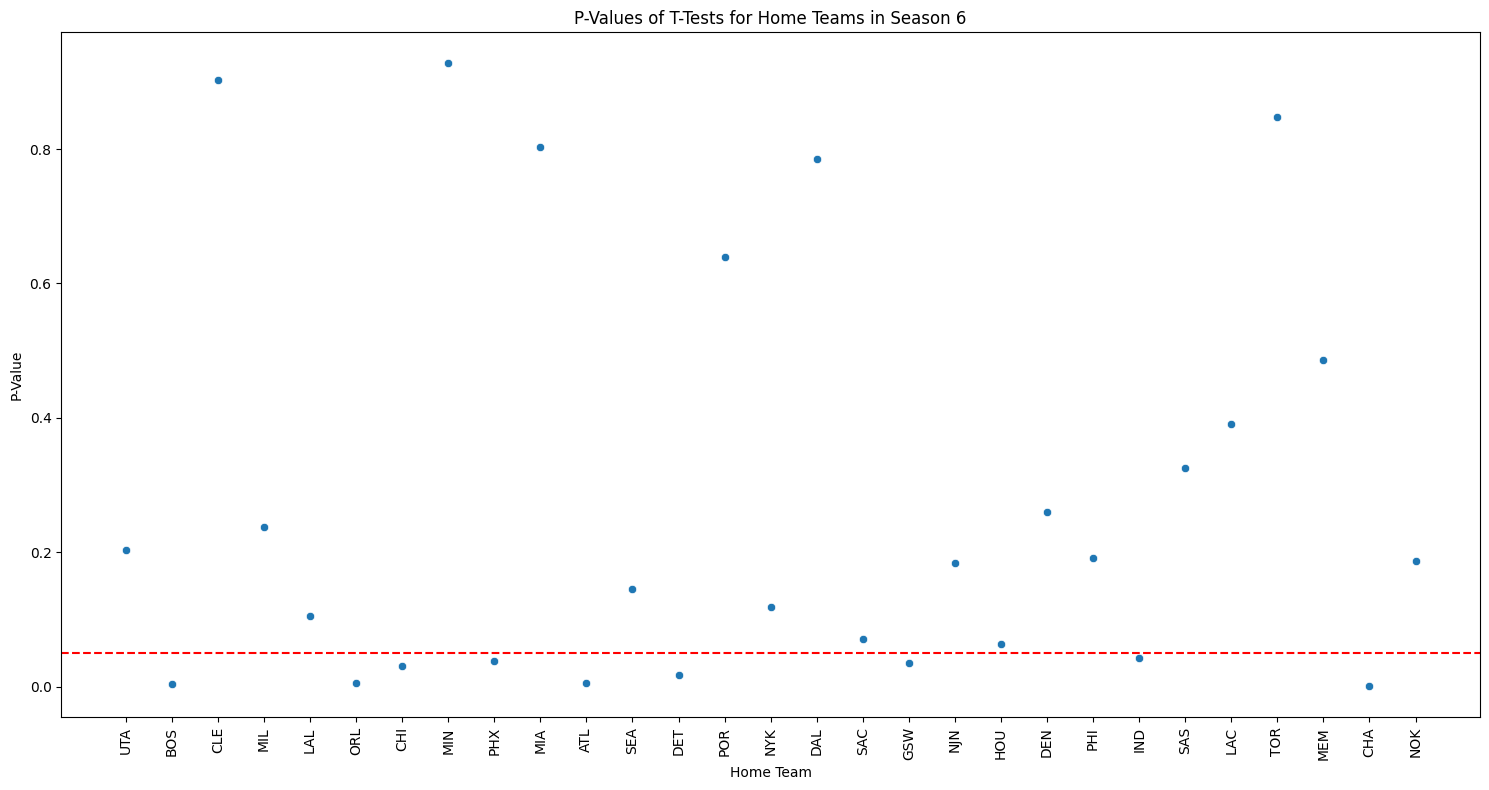

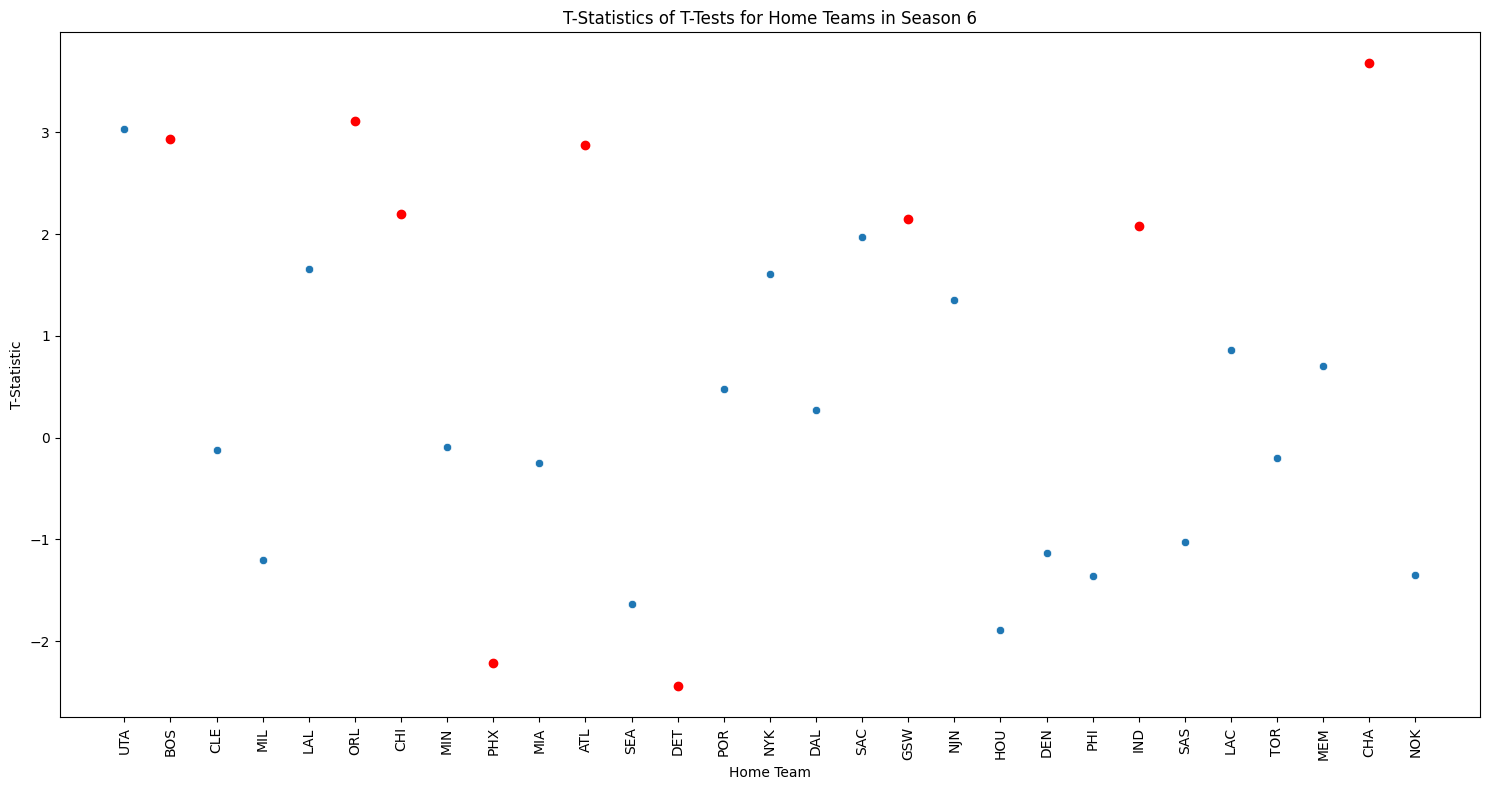

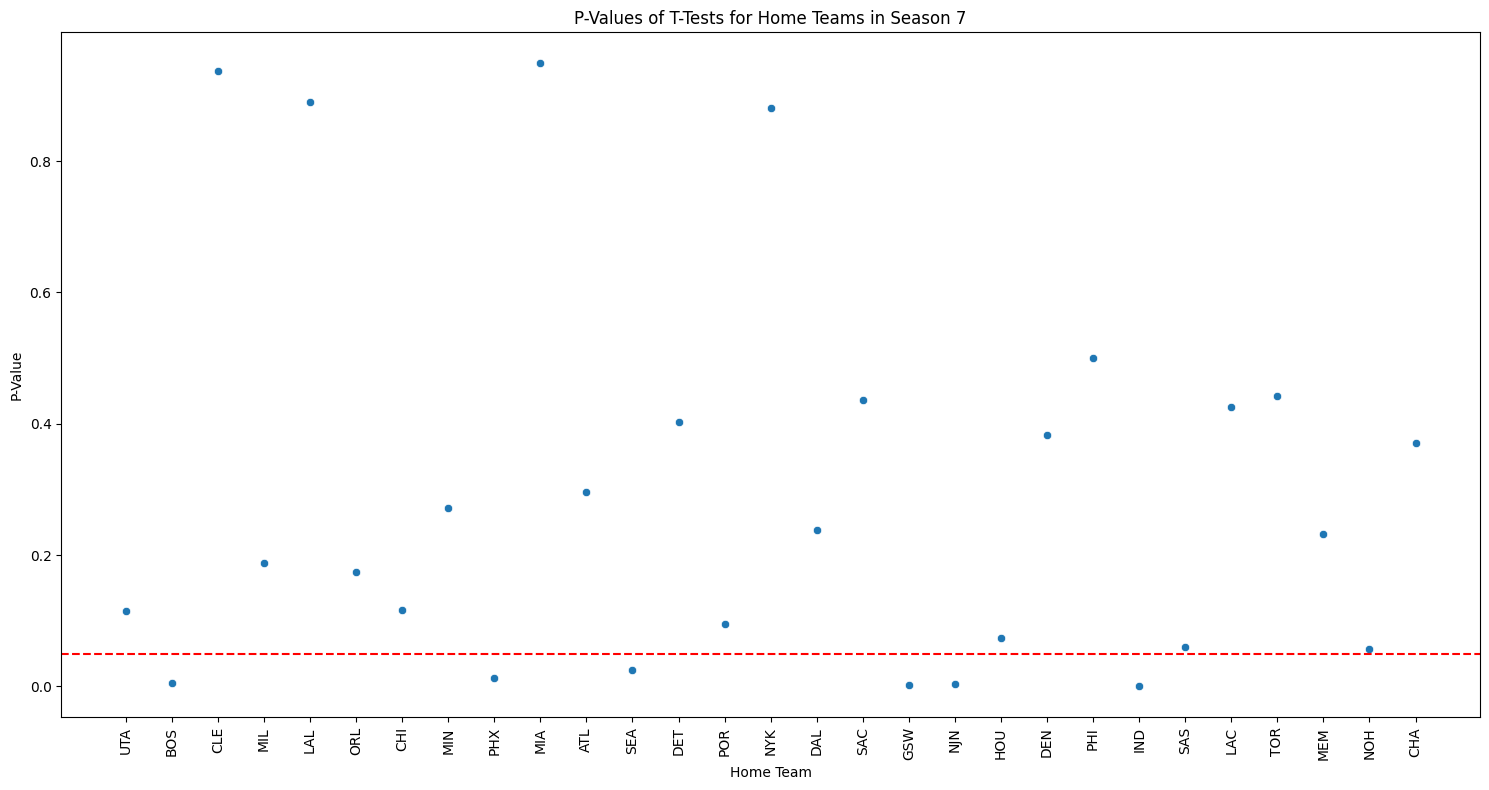

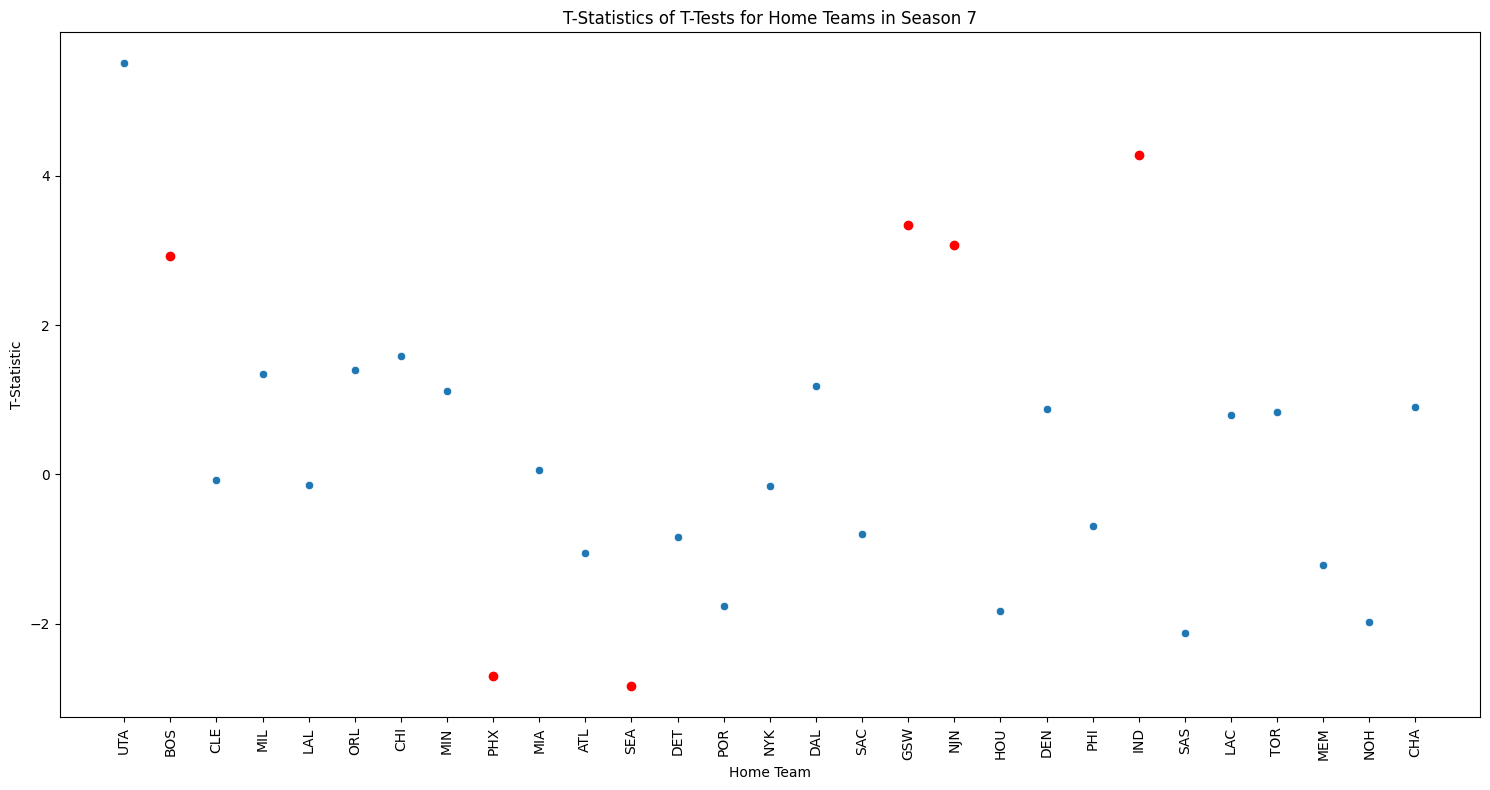

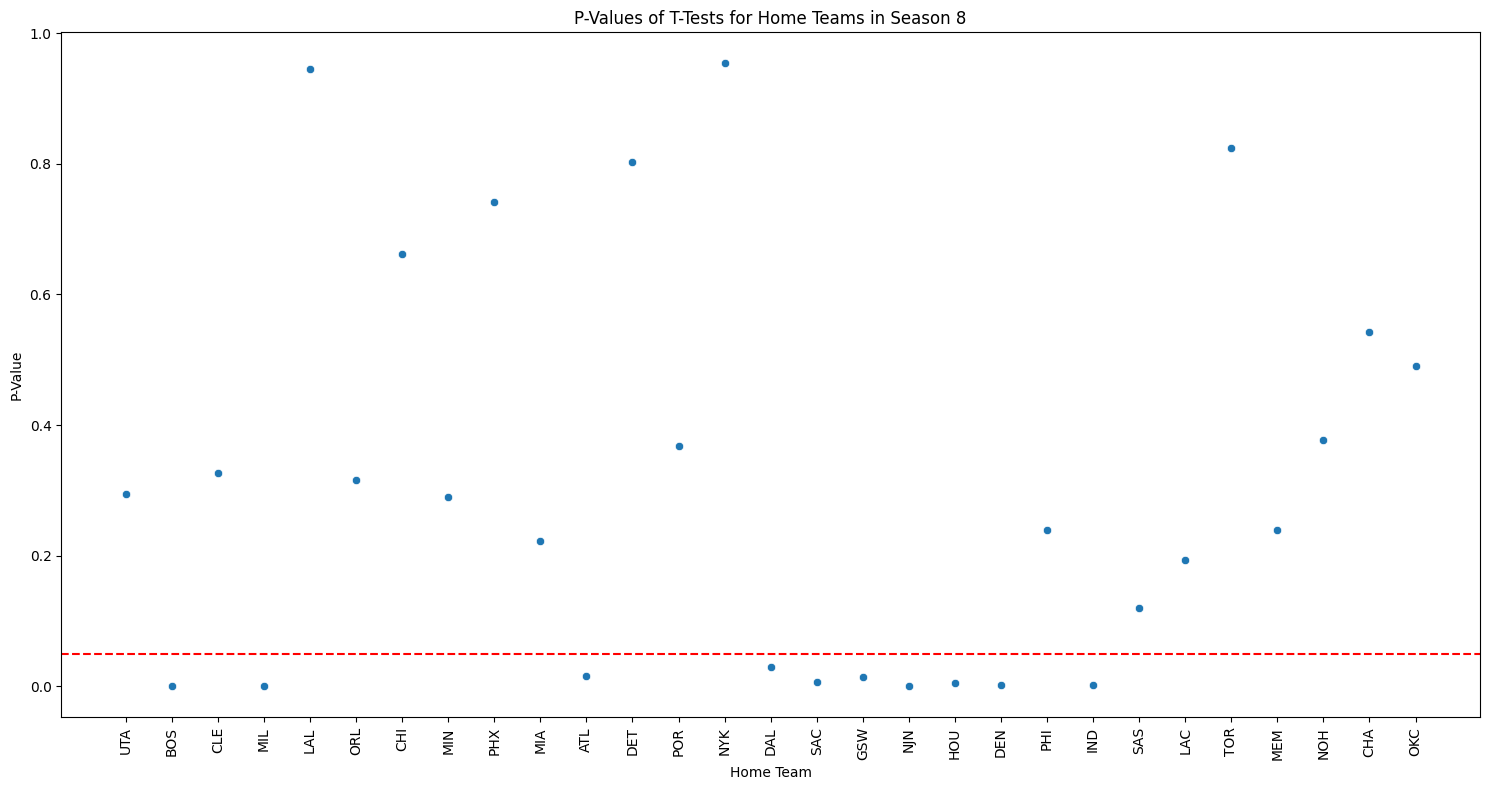

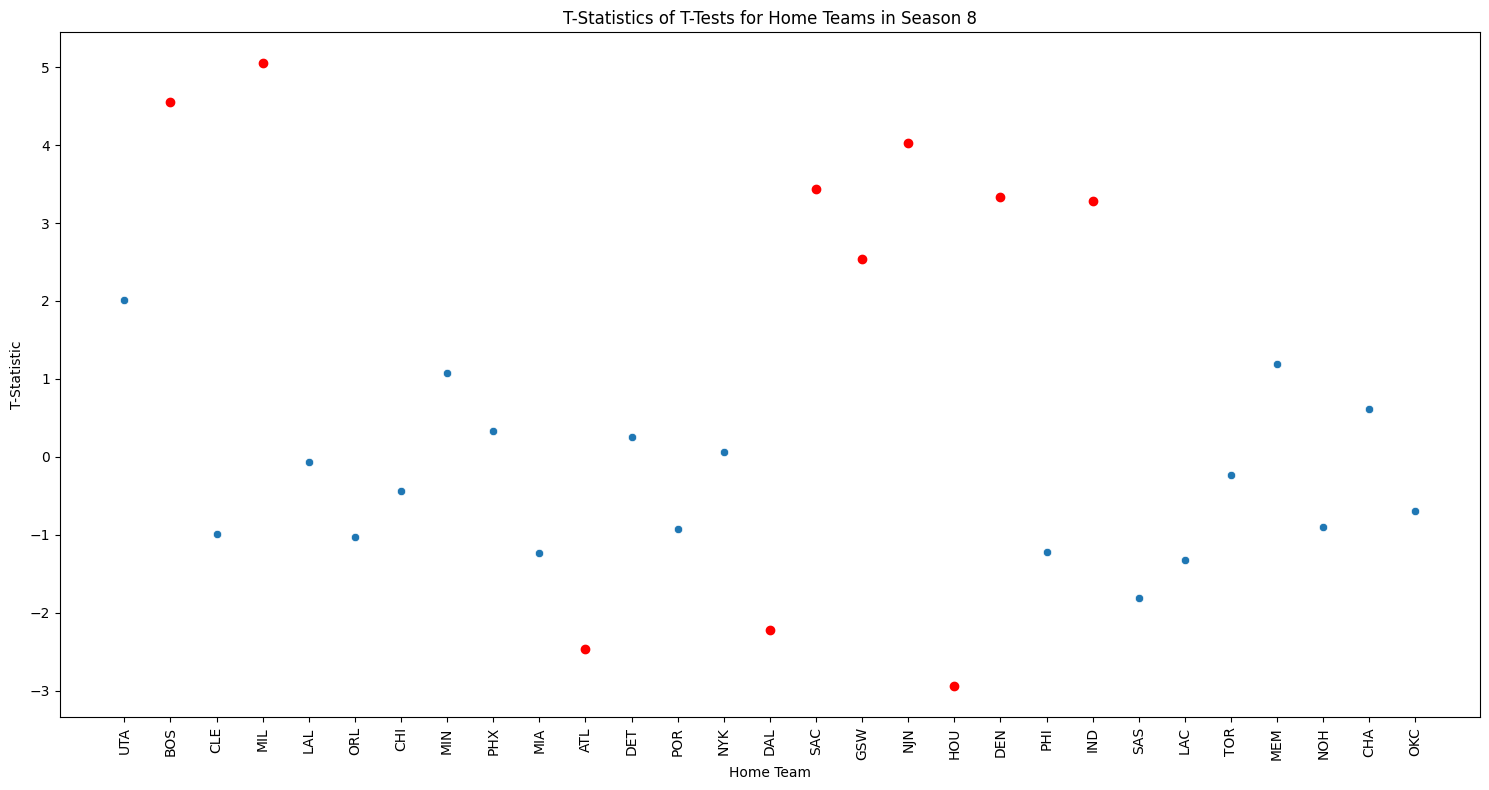

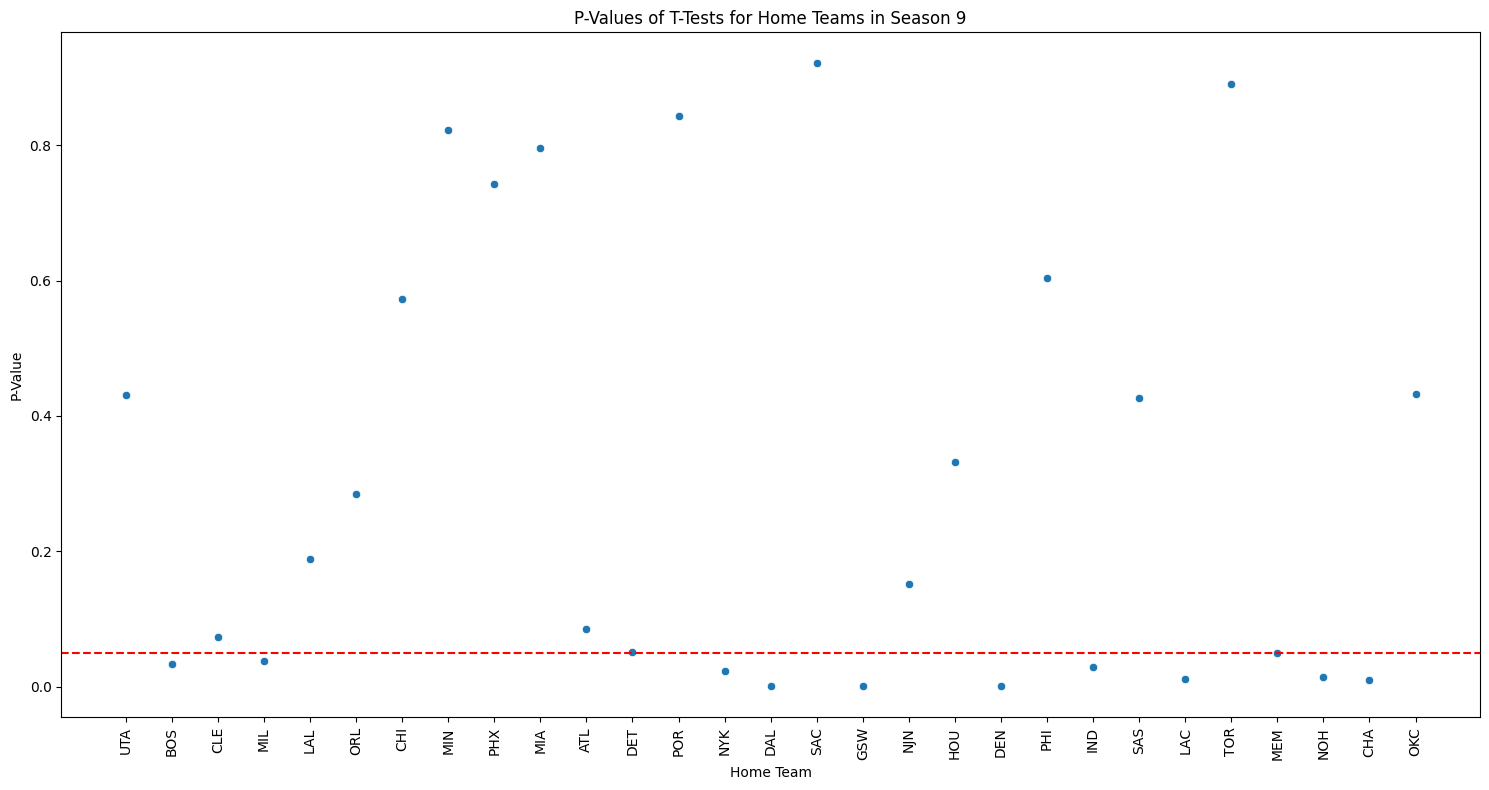

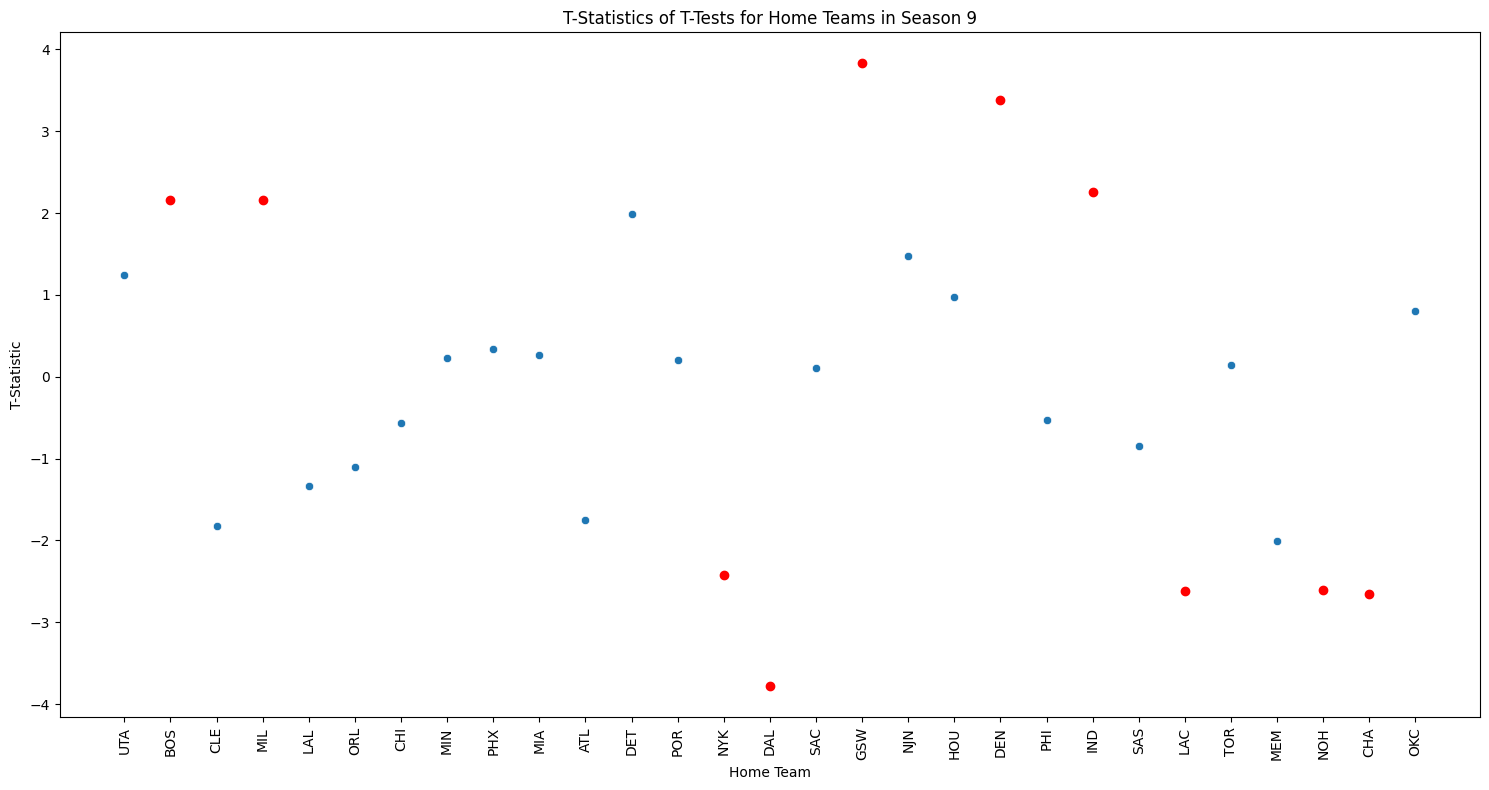

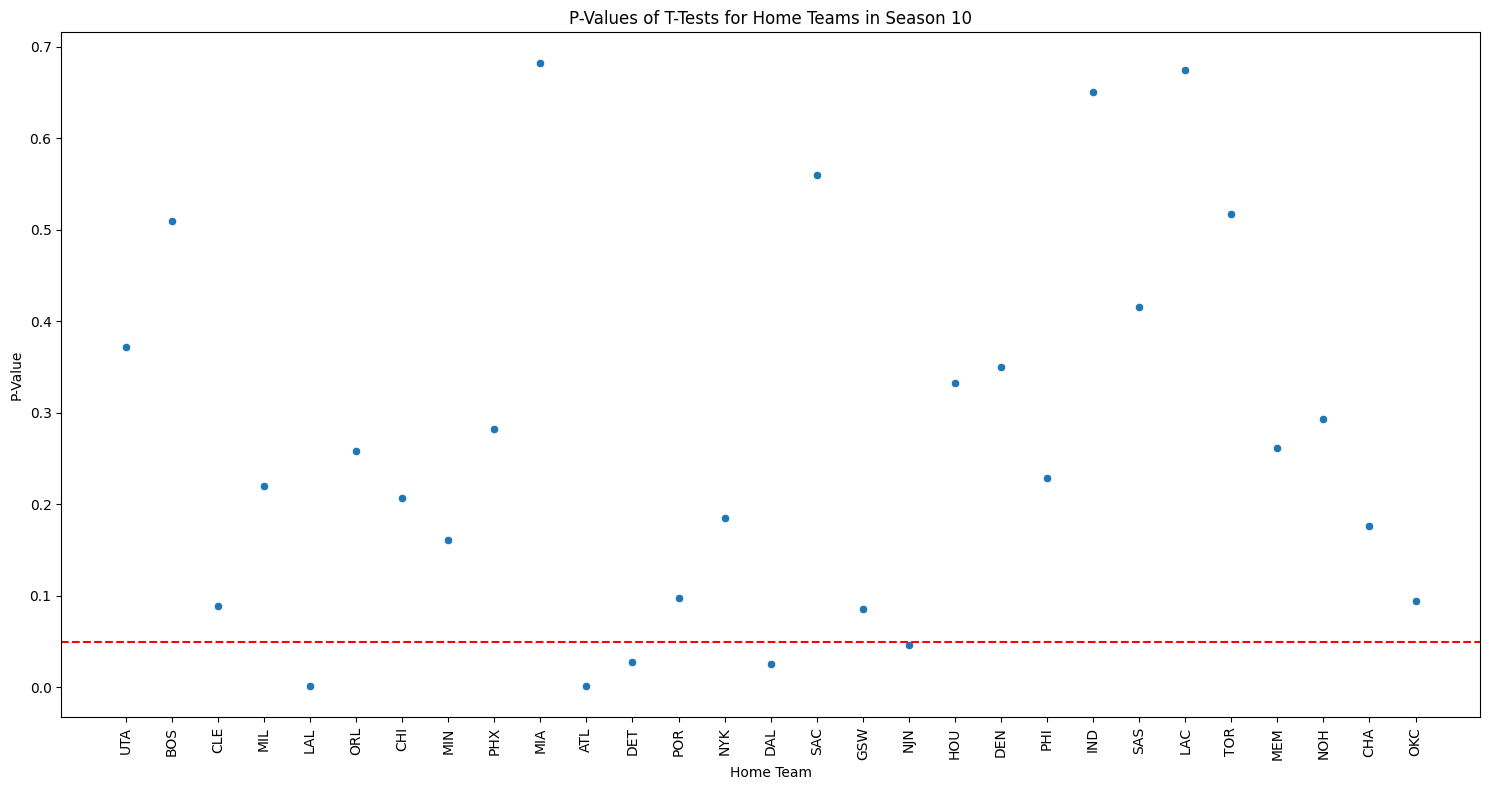

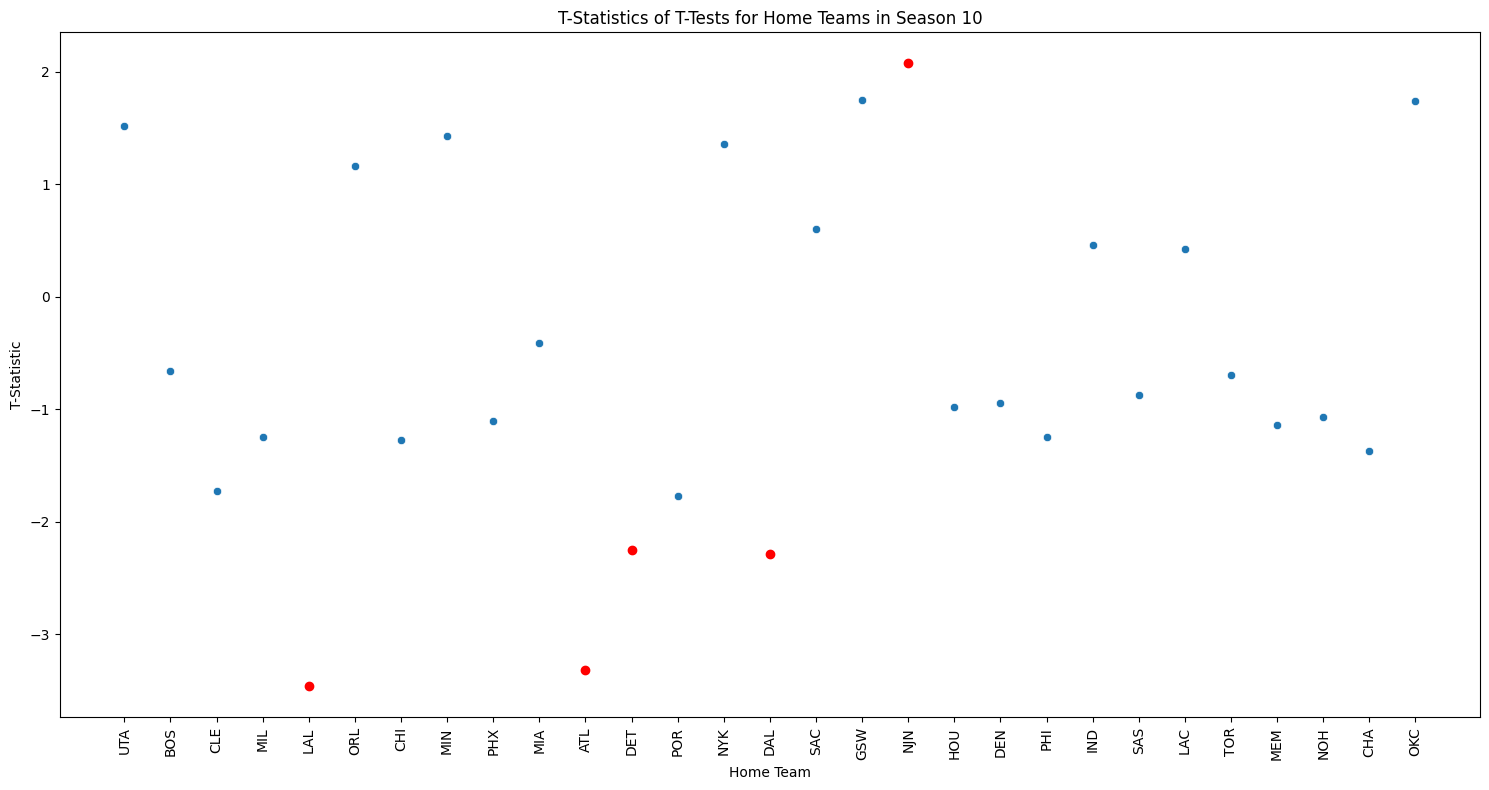

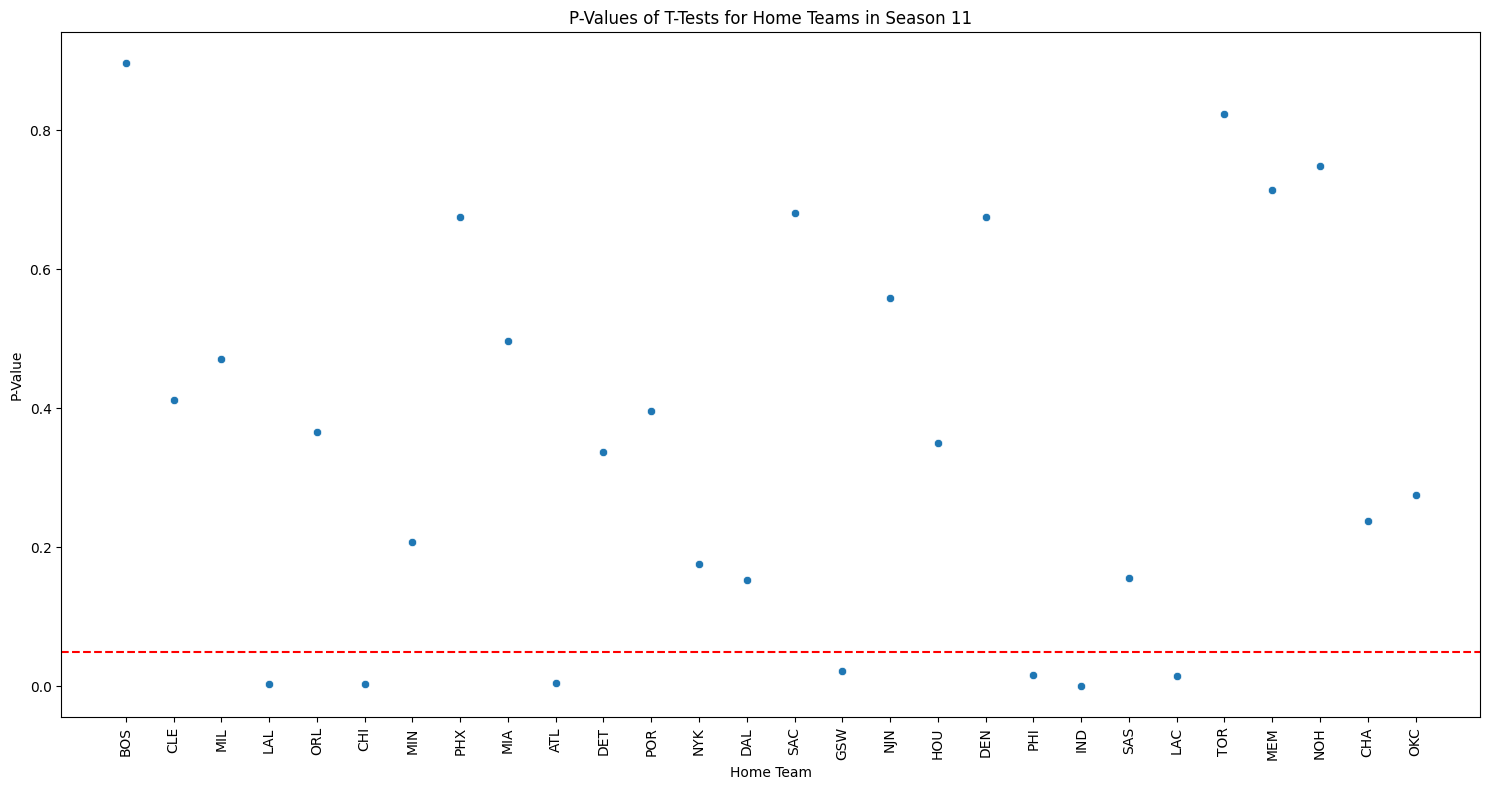

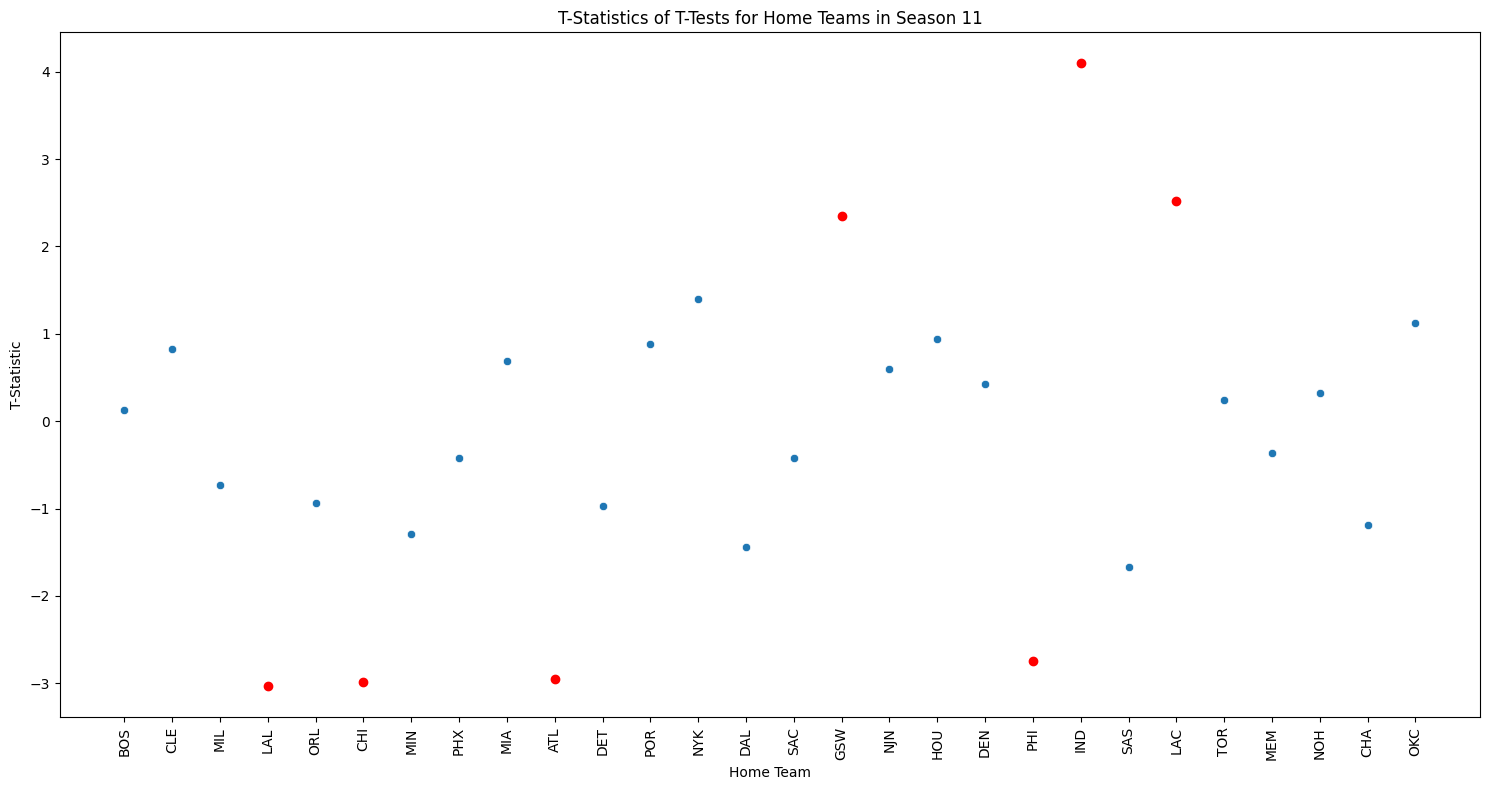

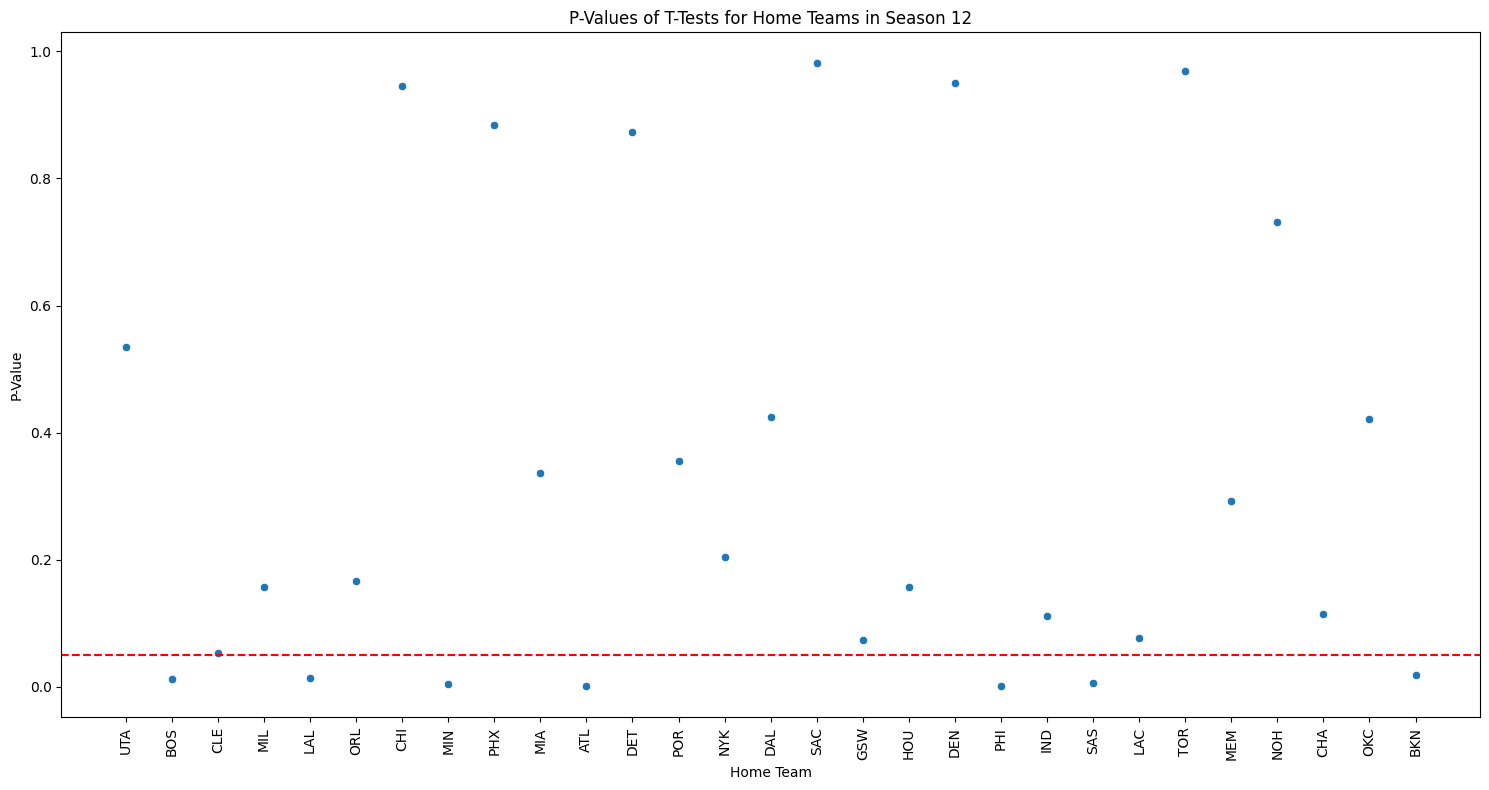

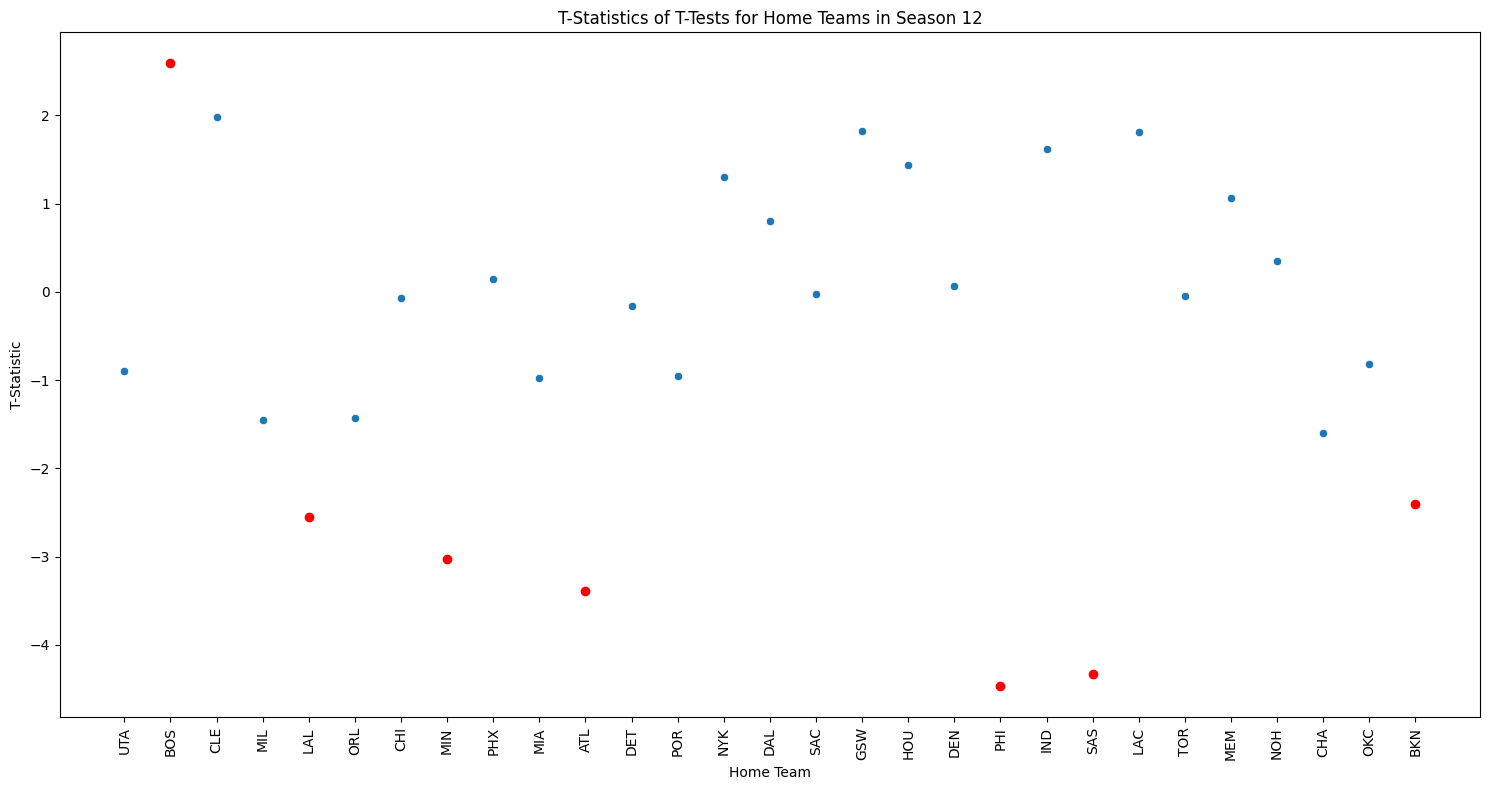

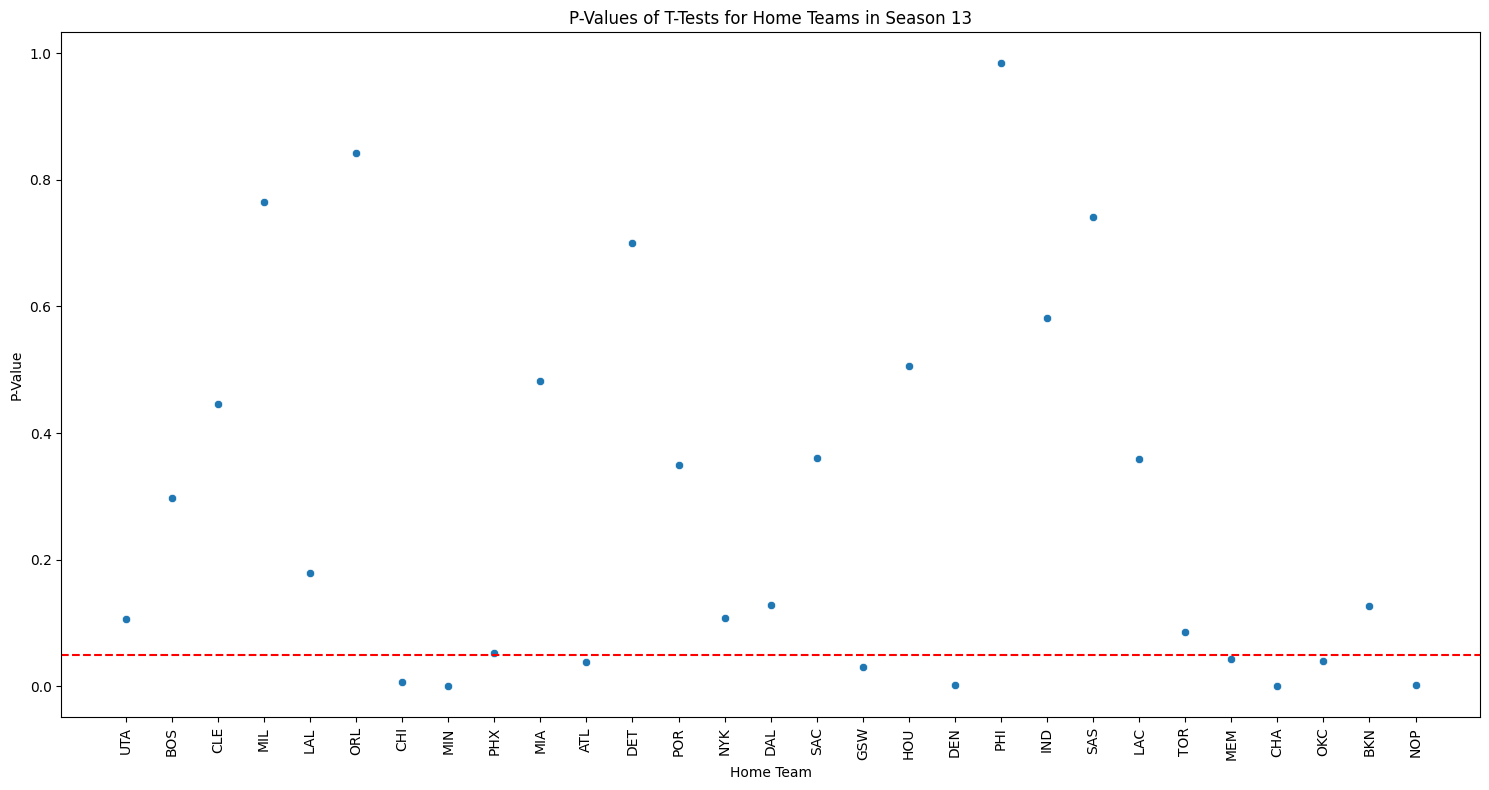

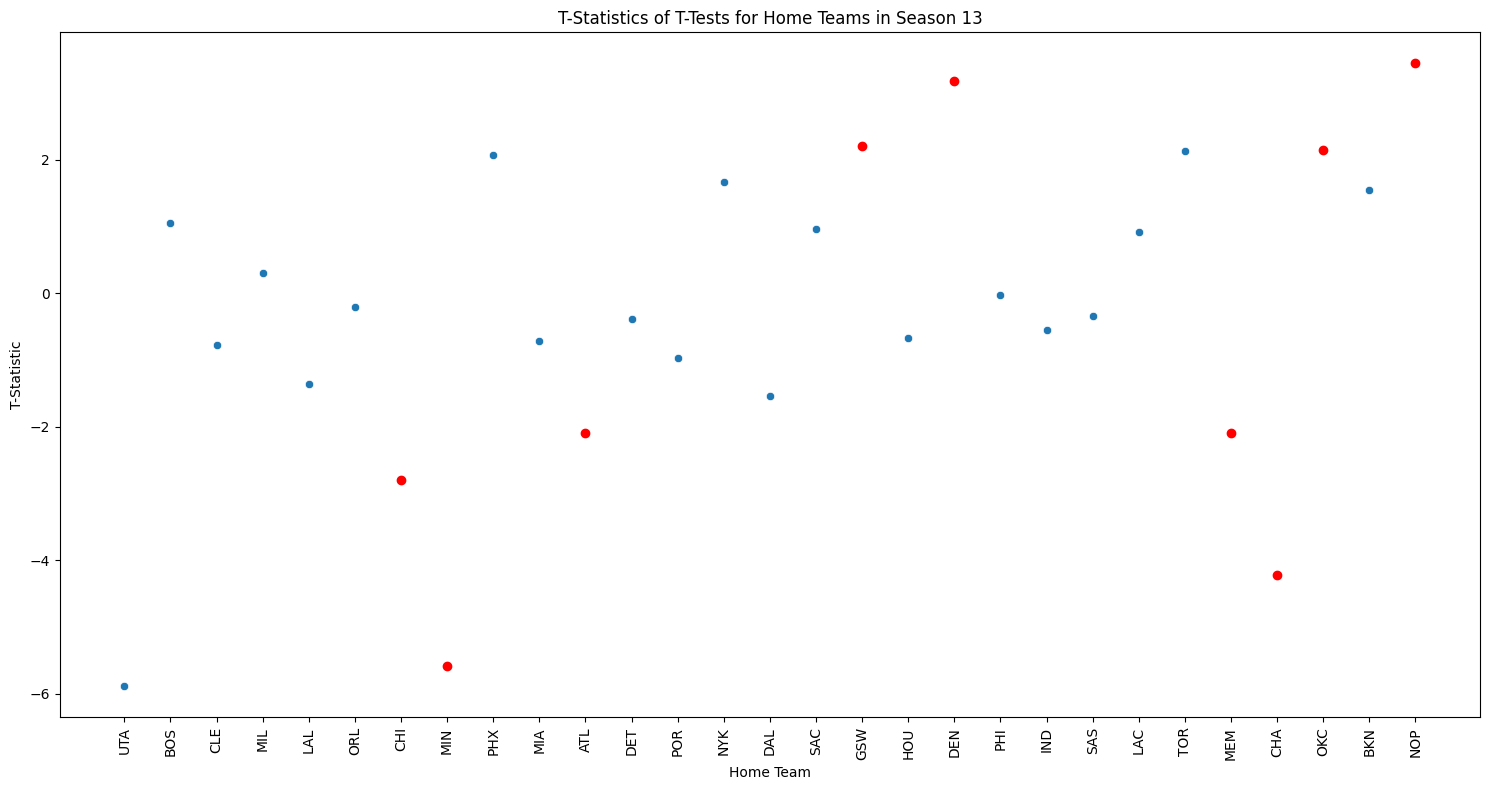

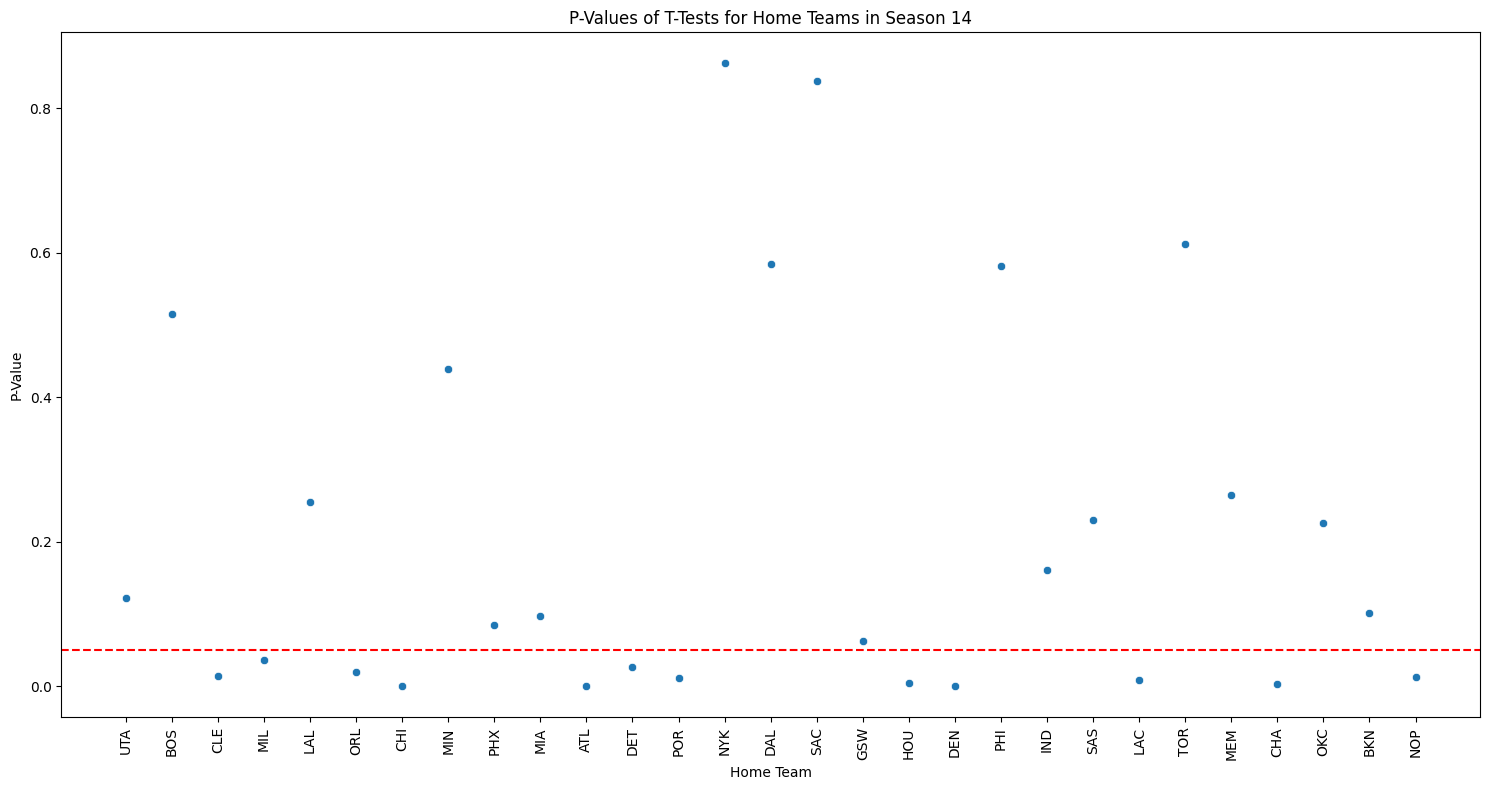

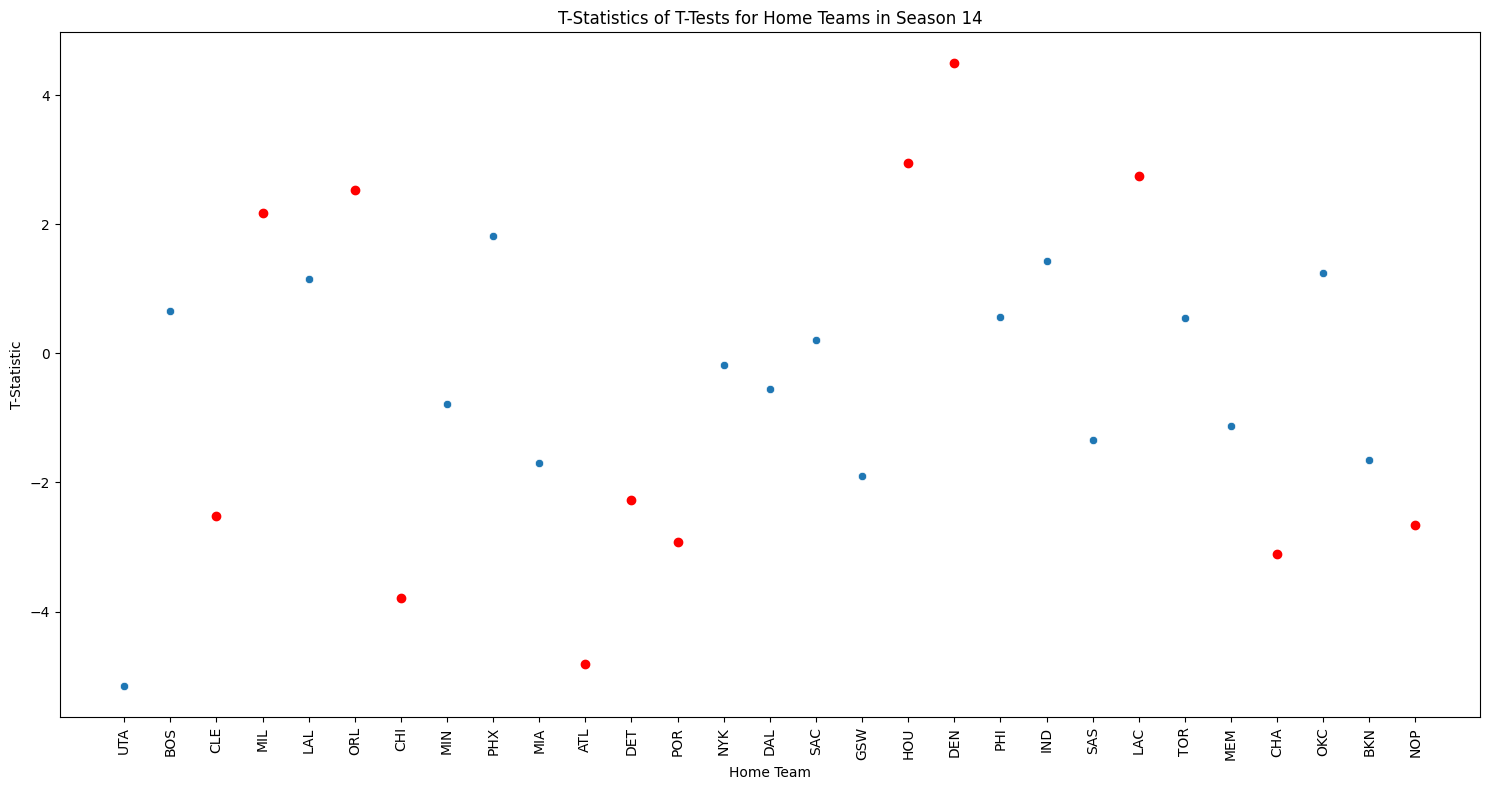

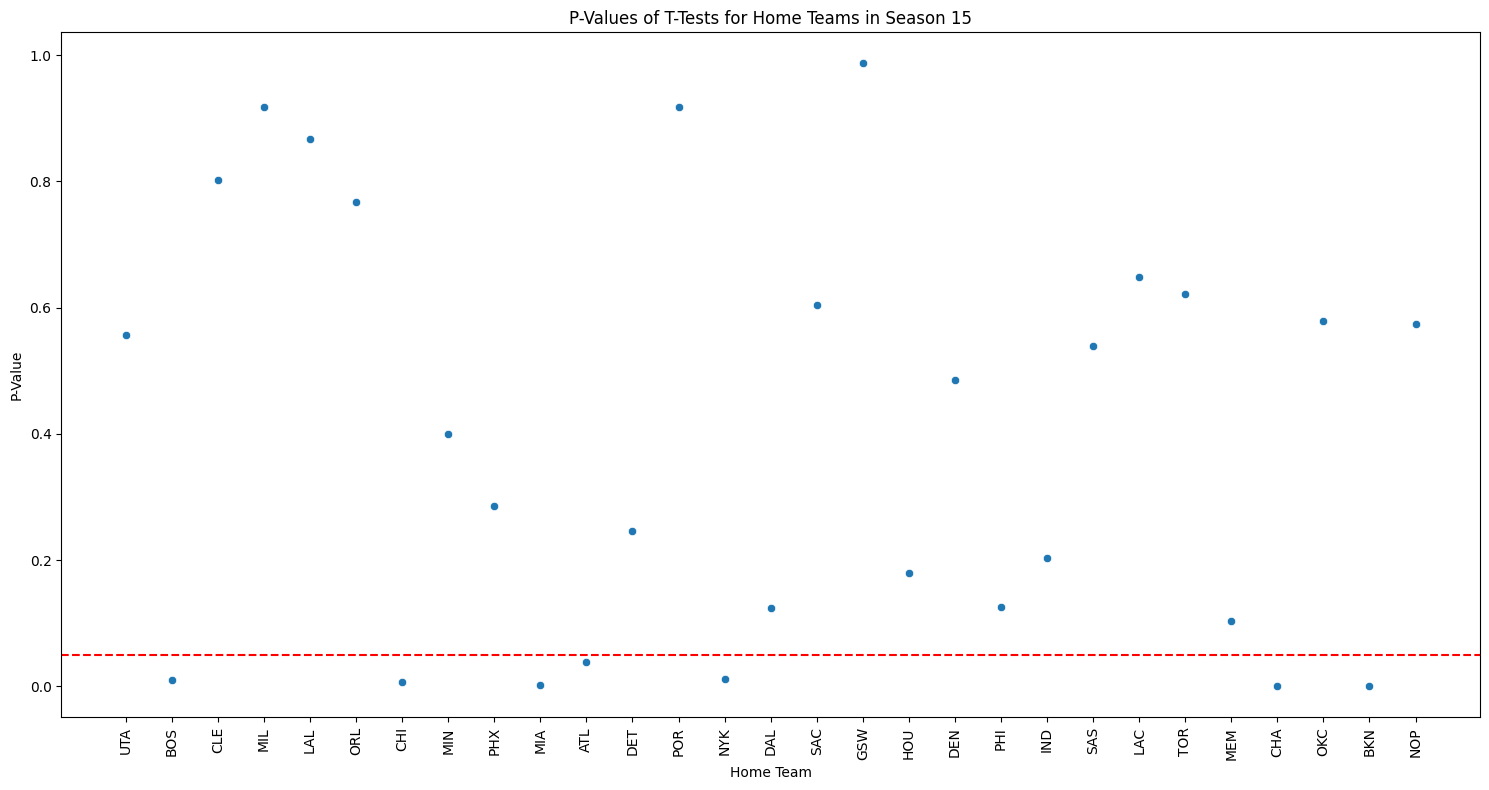

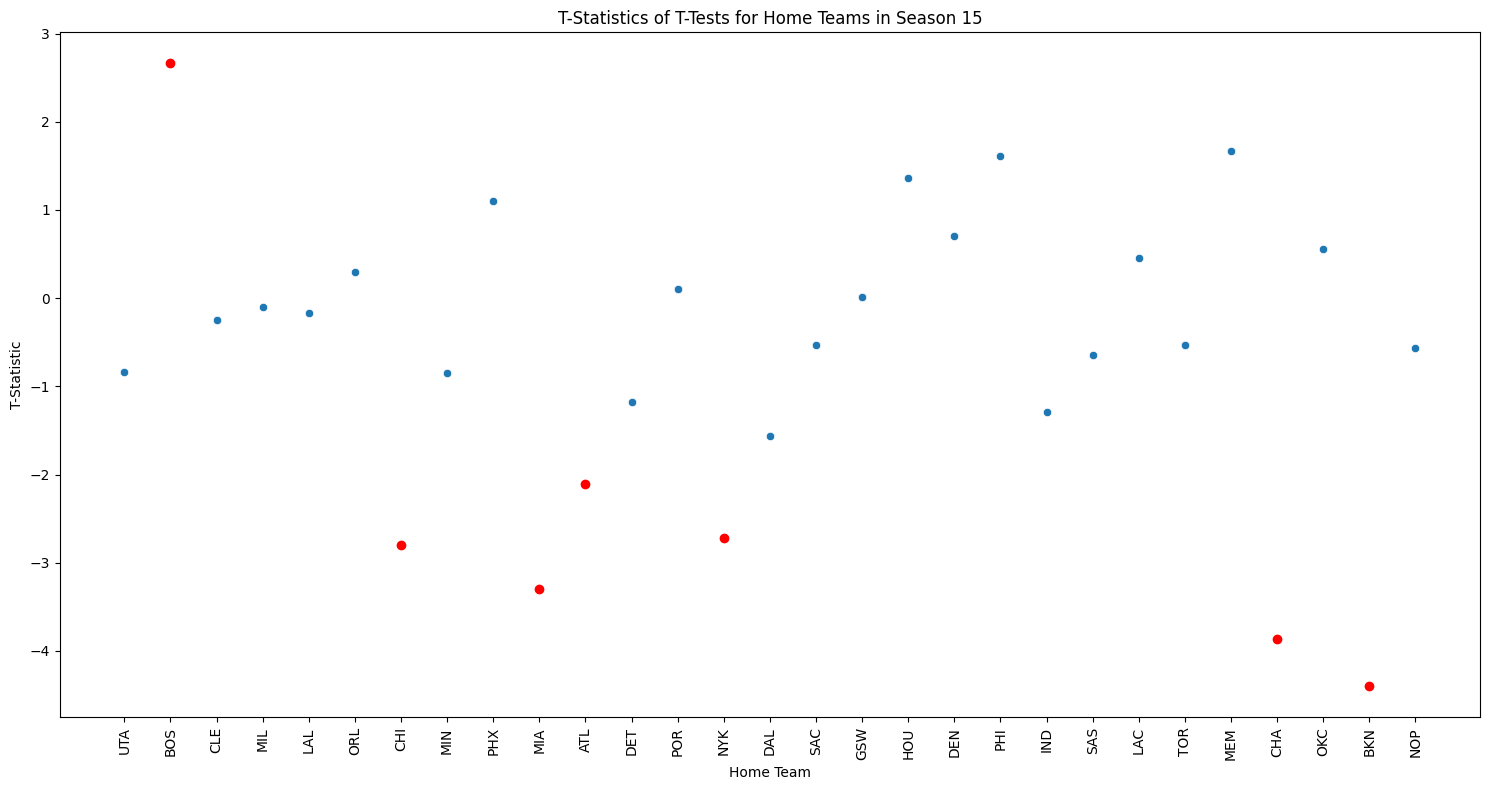

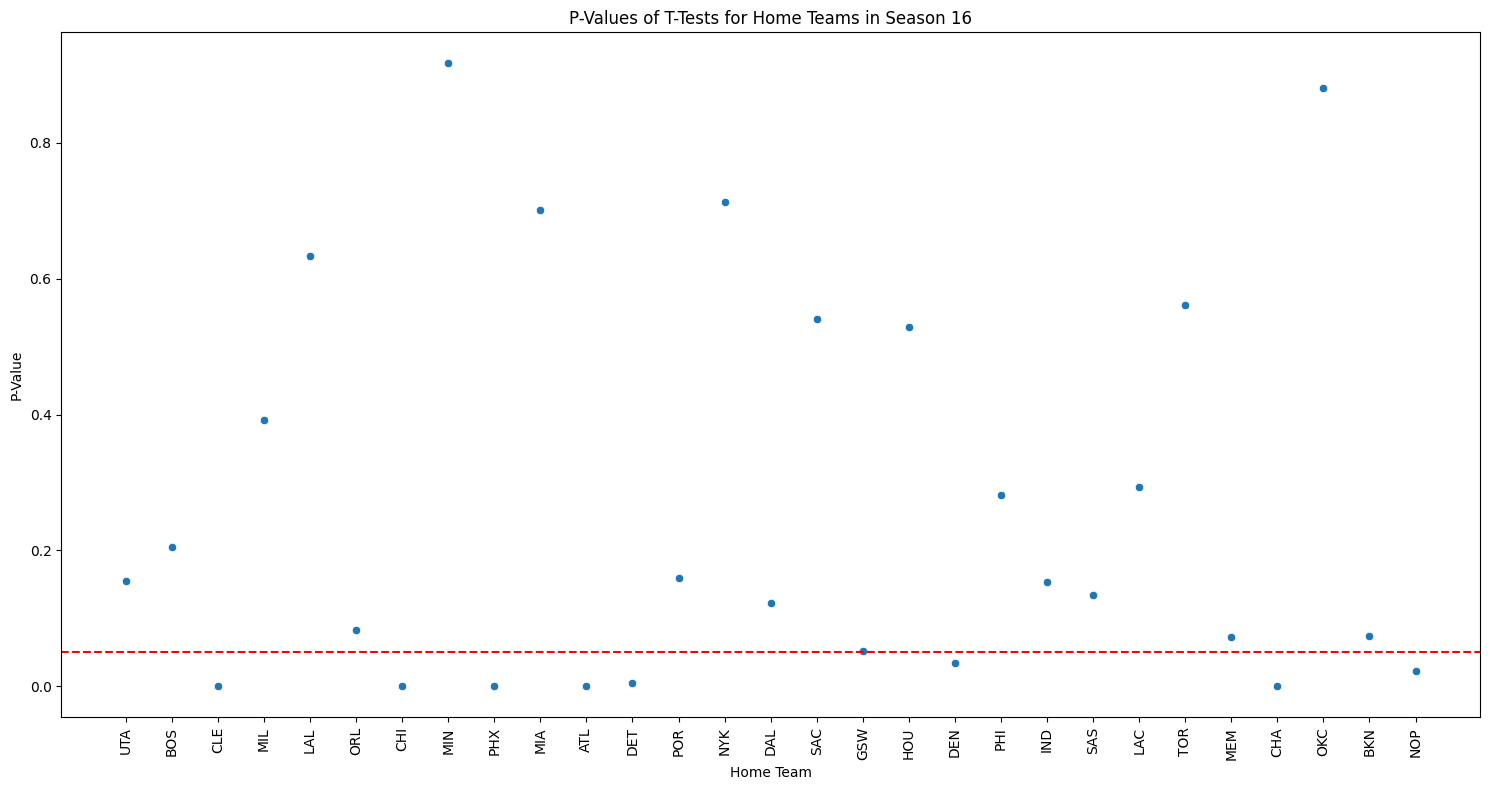

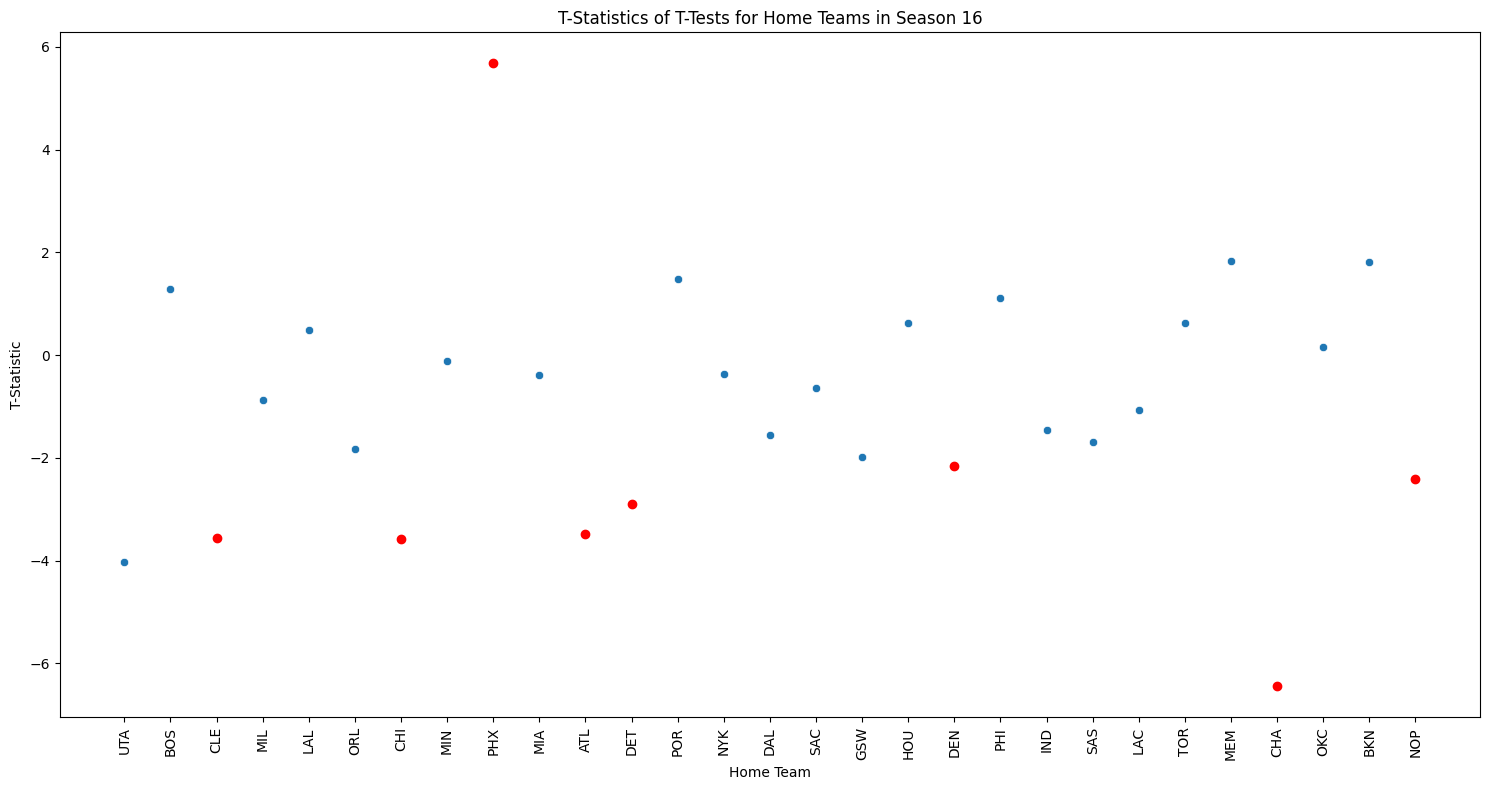

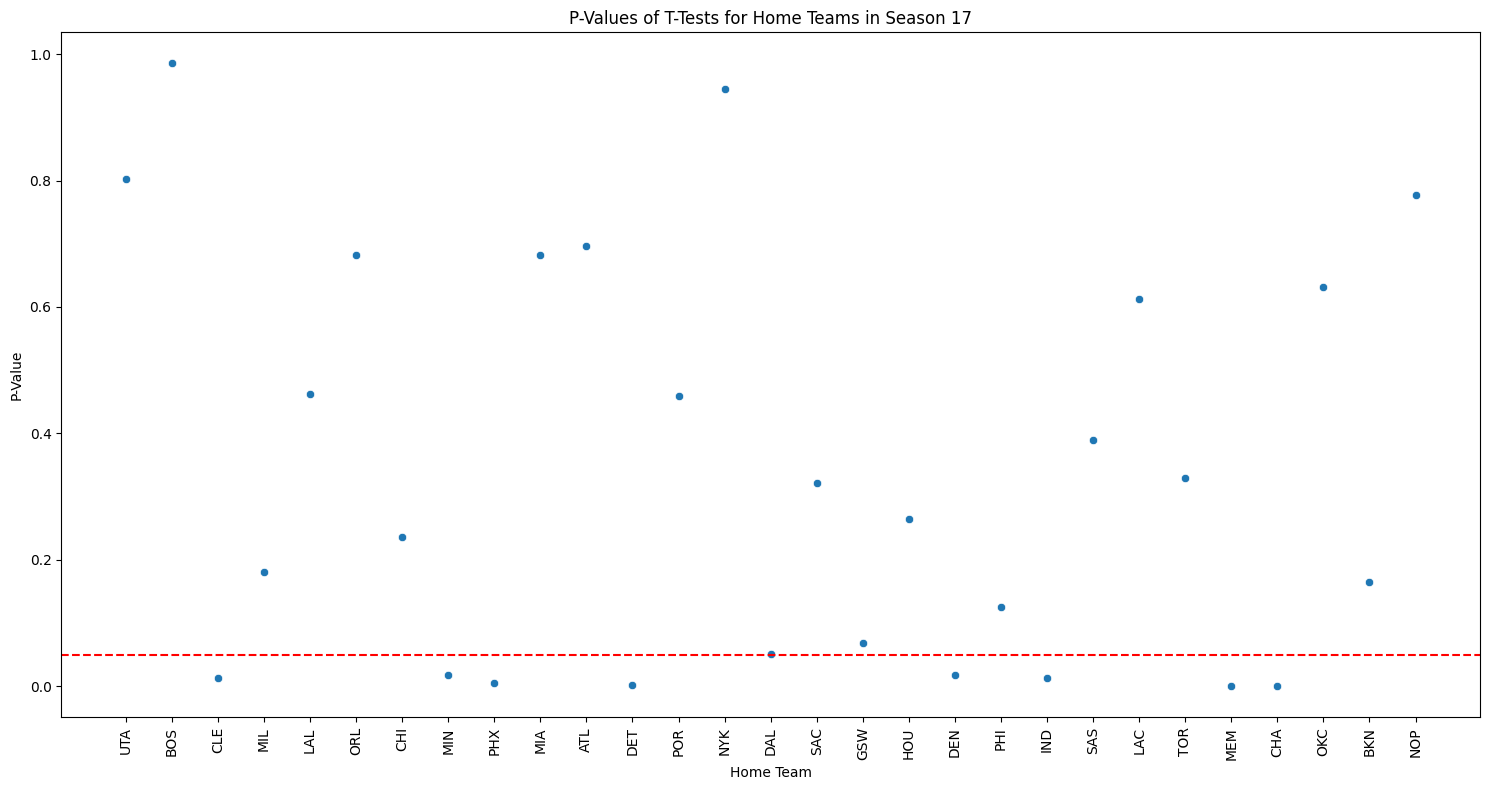

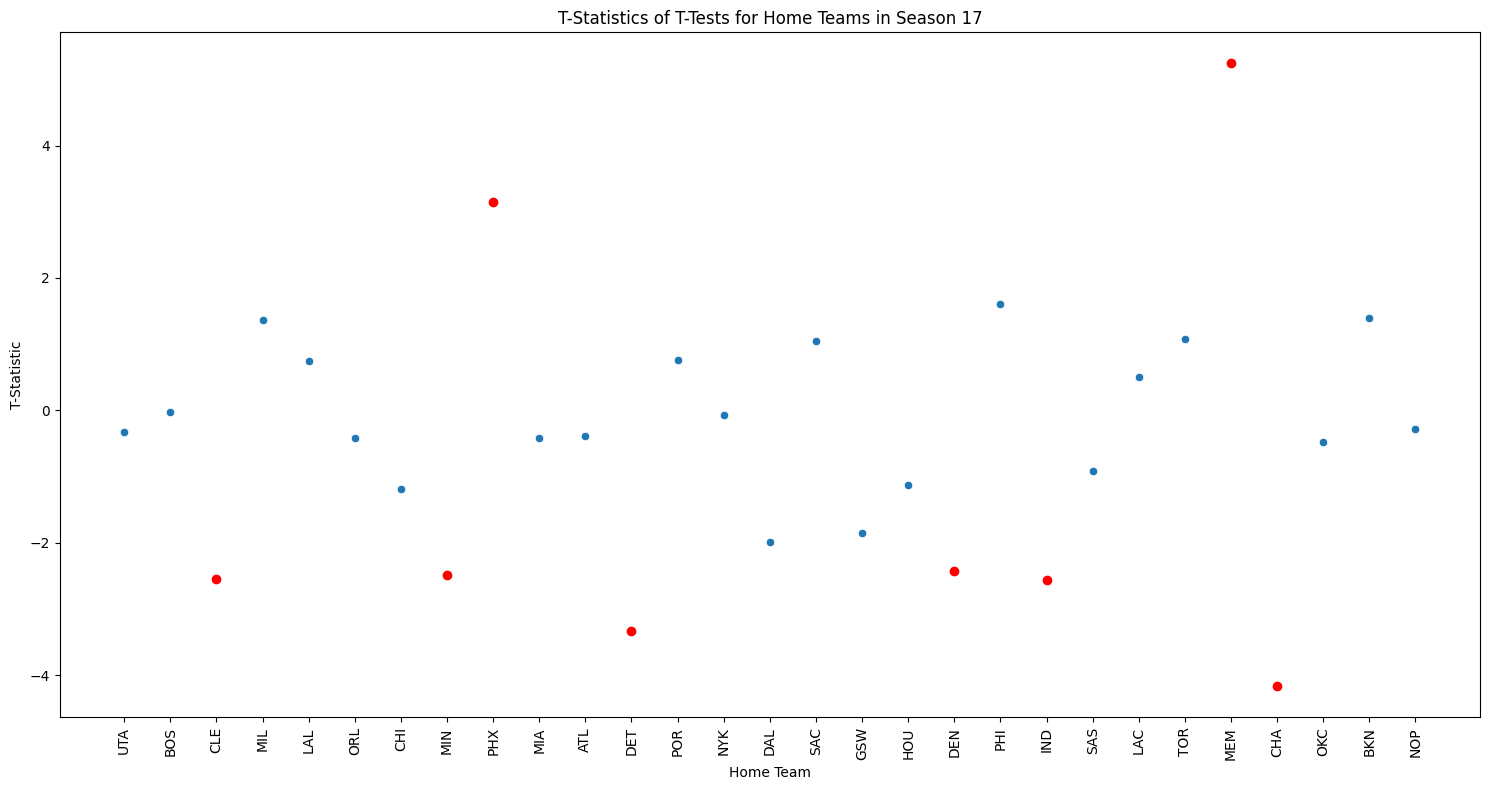

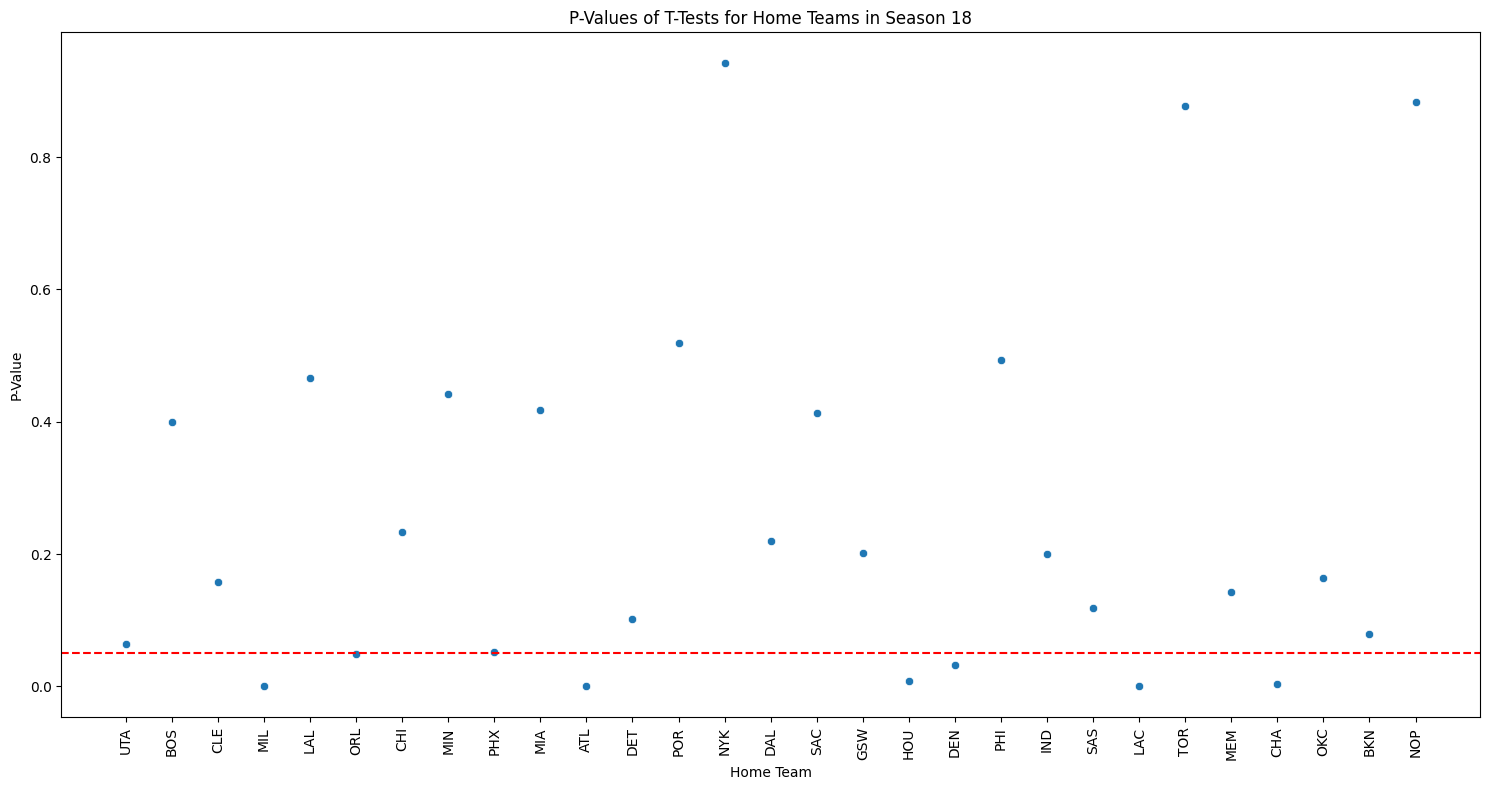

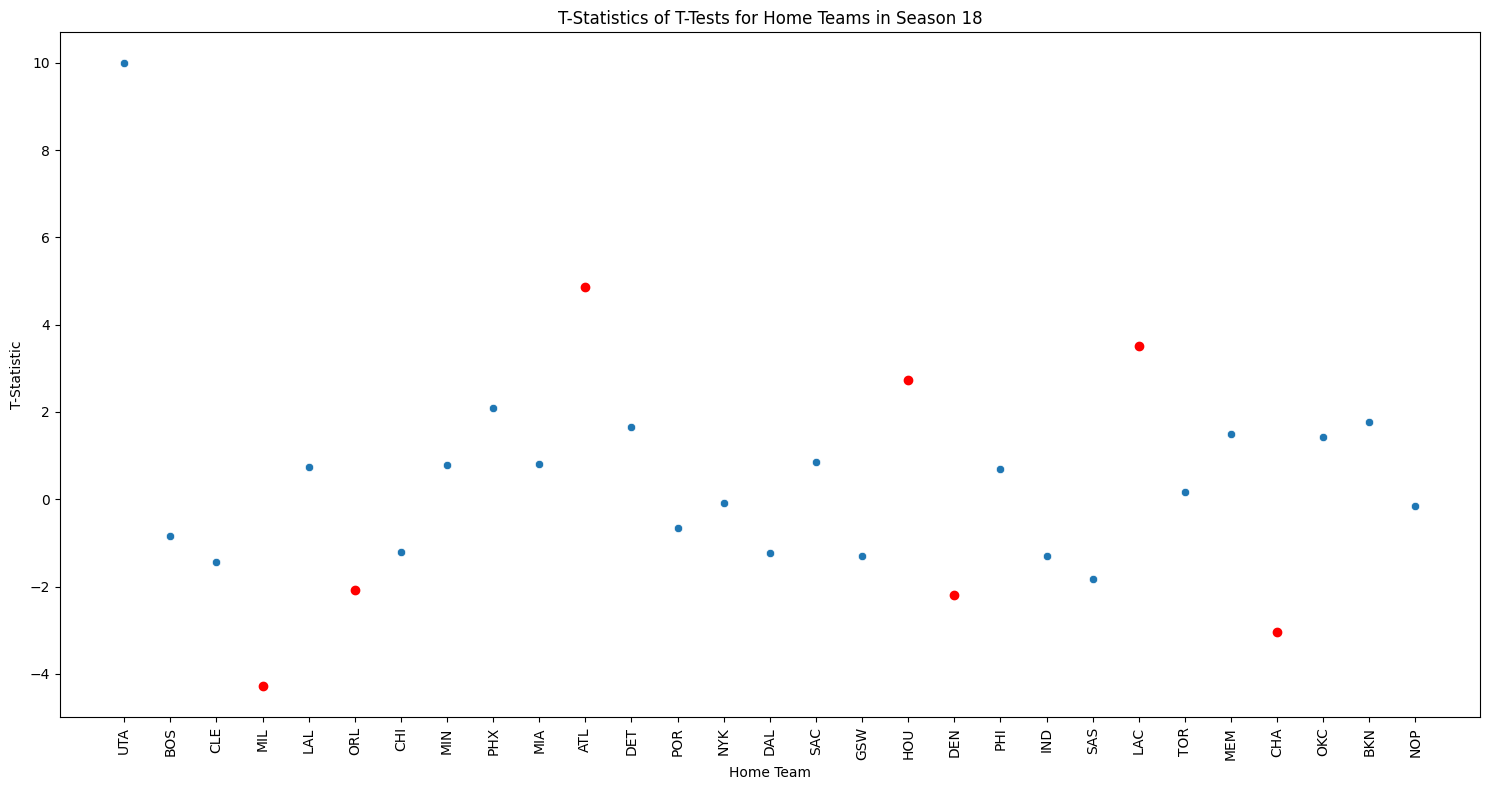

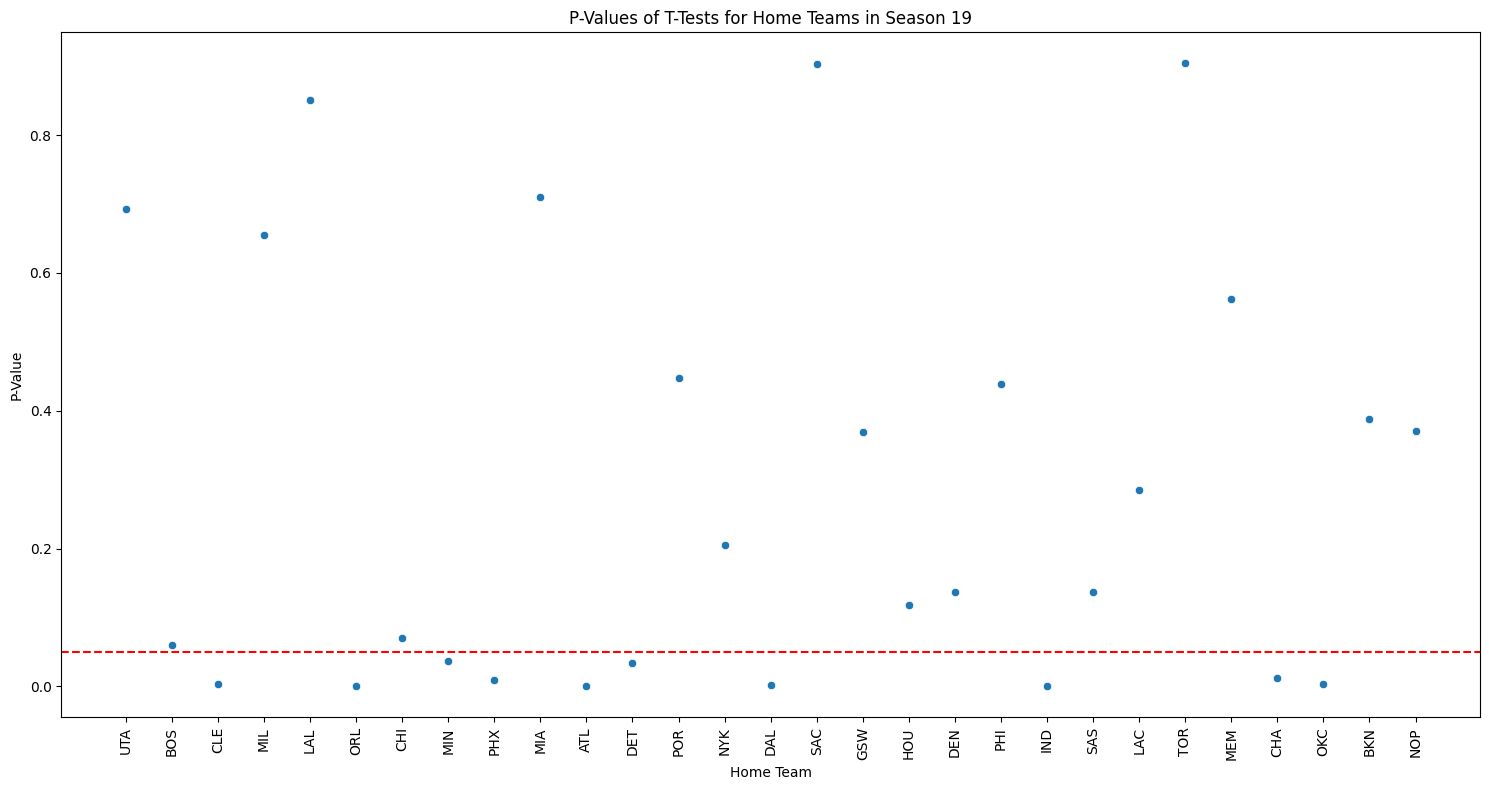

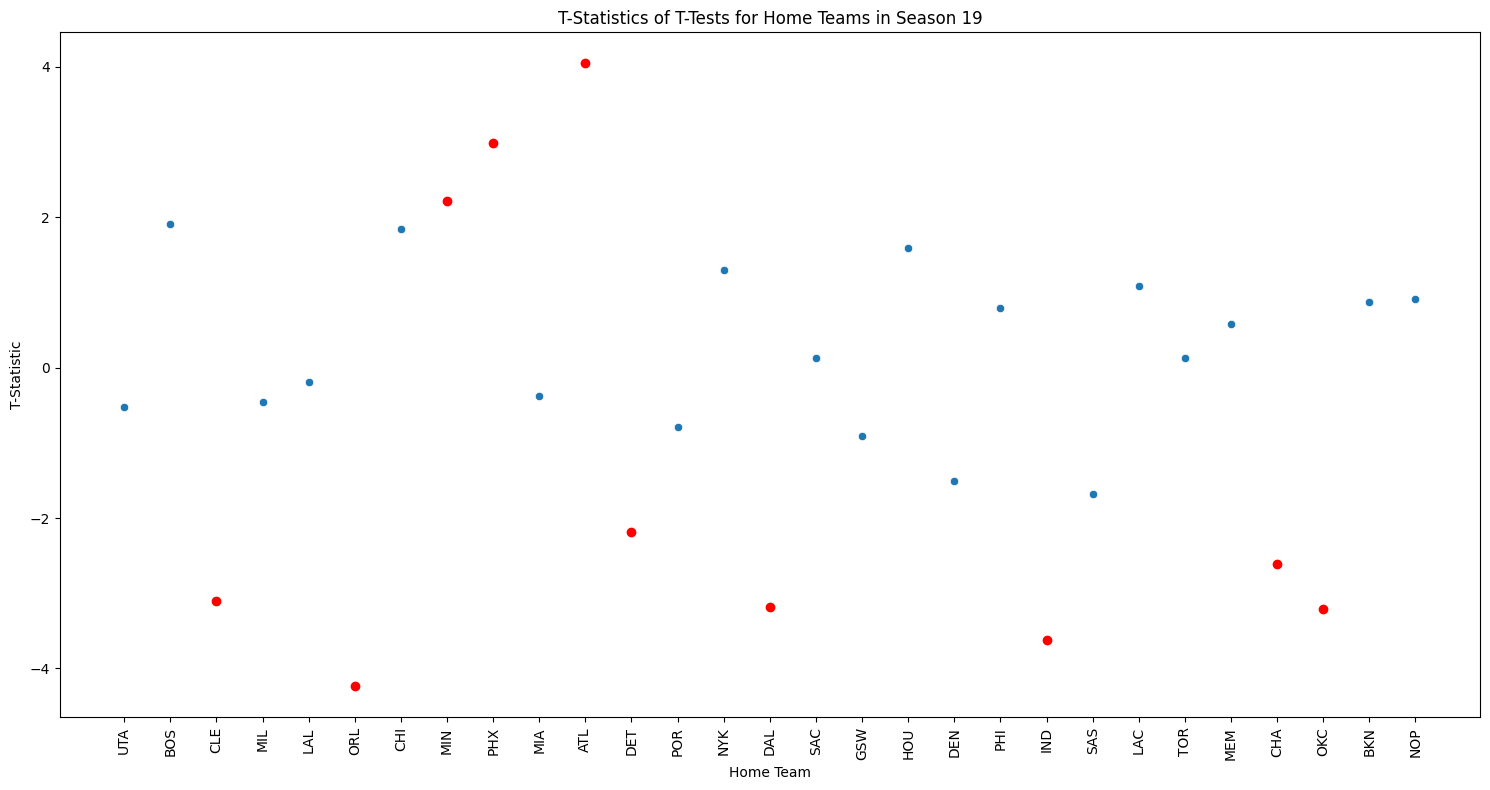

In [45]:
"""Plotting per Season"""

# Resetting the index of the DataFrame
df_for_plot = season_team_t_test_results_df.reset_index()

# Getting unique seasons
unique_seasons = df_for_plot['Season'].unique()

# Create a plot for each season
for season in unique_seasons:
    # Filter the DataFrame for the current season
    season_data = df_for_plot[df_for_plot['Season'] == season]

    # Plot for p-values
    plt.pyplot.figure(figsize=(15, 8))
    sns.scatterplot(data=season_data, x='Home Team', y='p_value')
    plt.pyplot.axhline(0.05, color='red', linestyle='--')
    plt.pyplot.xticks(rotation=90)
    plt.pyplot.title(f'P-Values of T-Tests for Home Teams in Season {season}')
    plt.pyplot.ylabel('P-Value')
    plt.pyplot.xlabel('Home Team')
    plt.pyplot.tight_layout()
    plt.pyplot.show()

    # Plot for t-statistics
    plt.pyplot.figure(figsize=(15, 8))
    sns.scatterplot(data=season_data, x='Home Team', y='t_statistic')
    plt.pyplot.xticks(rotation=90)
    # make dots red if the team had a statistically significant difference (p value < 0.05)
    for index, row in season_data.iterrows():
        if row['p_value'] < 0.05:
            plt.pyplot.scatter(row['Home Team'], row['t_statistic'], color='red')

    plt.pyplot.title(f'T-Statistics of T-Tests for Home Teams in Season {season}')
    plt.pyplot.ylabel('T-Statistic')
    plt.pyplot.xlabel('Home Team')
    plt.pyplot.tight_layout()
    plt.pyplot.show()

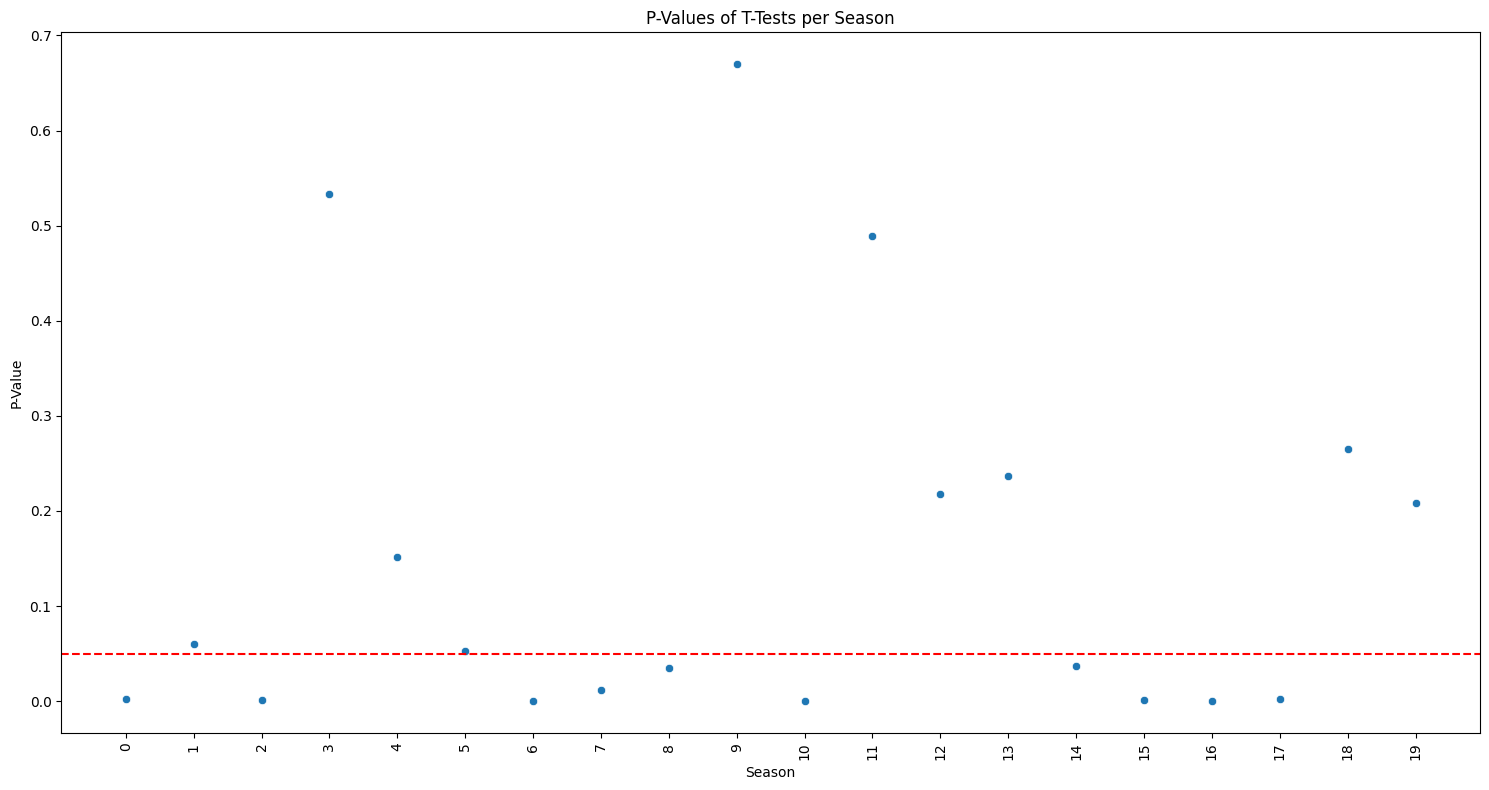

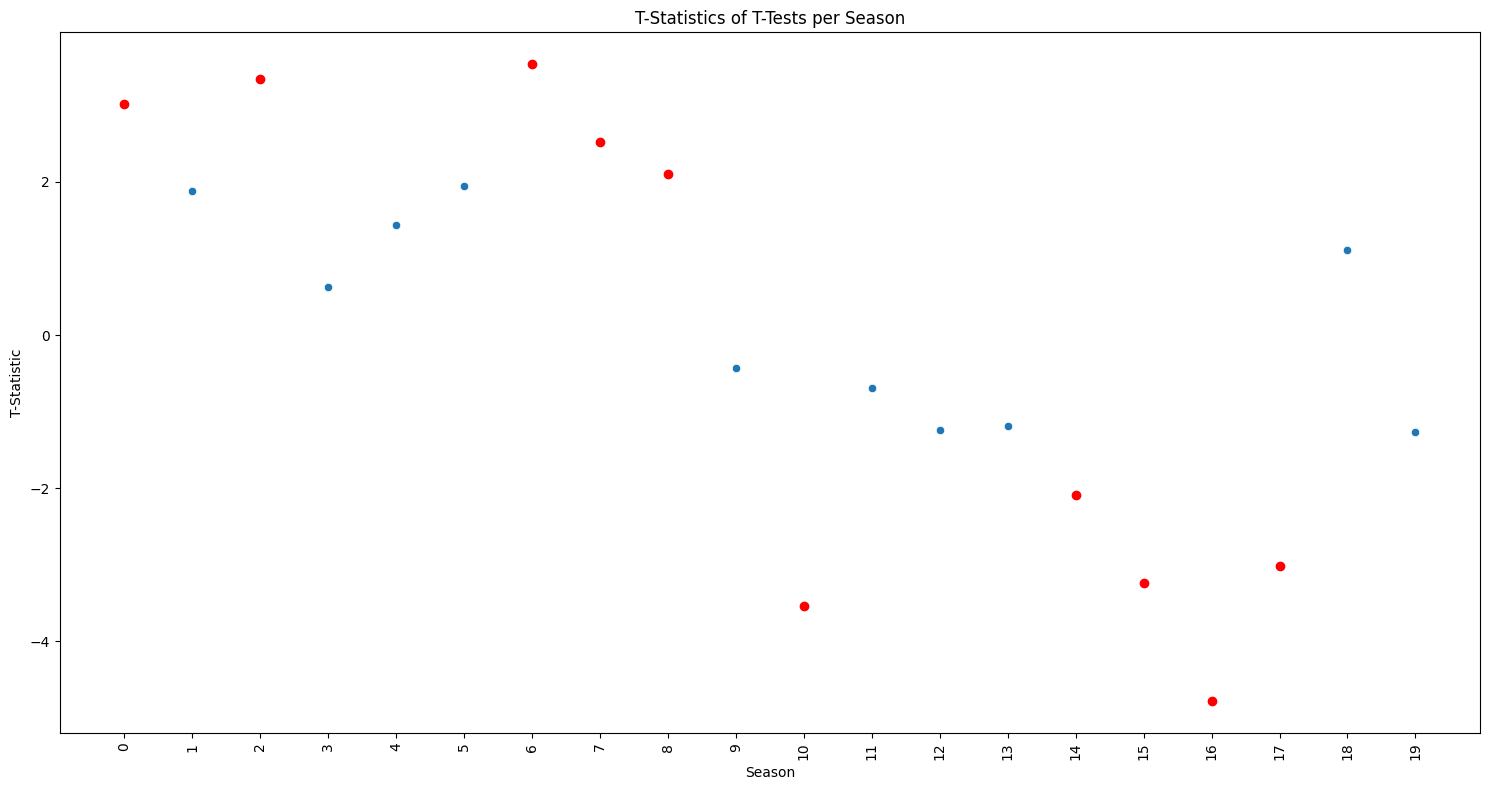

In [43]:
# reset index of the DataFrame

# Plot per season
plt.pyplot.figure(figsize=(15, 8))
sns.scatterplot(data=season_t_test_results_df, x='index', y='p_value')
# make x axis discrete instead of continuous
plt.pyplot.xticks(range(len(season_t_test_results_df)), season_t_test_results_df['index'])
plt.pyplot.axhline(0.05, color='red', linestyle='--')
plt.pyplot.xticks(rotation=90)
plt.pyplot.title('P-Values of T-Tests per Season')
plt.pyplot.ylabel('P-Value')
plt.pyplot.xlabel('Season')
plt.pyplot.tight_layout()
plt.pyplot.show()

# Plot per season
plt.pyplot.figure(figsize=(15, 8))
sns.scatterplot(data=season_t_test_results_df, x='index', y='t_statistic')
# make dots red if the team had a statistically significant difference (p value < 0.05)
plt.pyplot.scatter(x=filtered_season_t_test_results_df.index, y=filtered_season_t_test_results_df['t_statistic'], color='red')

plt.pyplot.xticks(range(len(season_t_test_results_df)), season_t_test_results_df['index'])
plt.pyplot.xticks(rotation=90)
plt.pyplot.title('T-Statistics of T-Tests per Season')
plt.pyplot.ylabel('T-Statistic')
plt.pyplot.xlabel('Season')
plt.pyplot.tight_layout()
plt.pyplot.show()

In [35]:
# Download the results and data as CSV files
team_t_test_results_df.to_csv('team_t_test_resultss.csv')
season_team_t_test_results_df.to_csv('season_team_t_test_results.csv')
season_t_test_results_df.to_csv('season_t_test_results.csv')
df.to_csv('fouls_with_std_devs.csv')